# Project description
Urban mobility significantly contributes to global environmental impact. With the growth in urbanareas worldwide, cities are implementing policies to focus on sustainable urban and mobility devel-opment. Urban areas exhibit high variability in structure, economic output, mobility behaviour,among others. Pinpointing to the exact causes of emissions is impossible. However, understandingthe relationship of mobility with infrastructure resources and other urban indicators may help gov-ernments predict long-term mobility behaviour and intervene with future pathways into sustainablemobility options. </br>

Project goals: You are tasked to identify how mobility is related to the infrastructural form of acity and across multiple cities. Use your findings toward helping governments transform mobilitywithin cities for reducing environmental impacts of mobility use.
Data: </br>
1. Local city-wide indicators of urban mobility: Multi-city Traffic Datasetprovided publicly byThe Institute for Transport Planning and Systems at ETH Zurich.
2. Global city-wide indicators of urban mobility and environmental impacts:Urban TypologiesProject[Reference]3.Get indicators for infrastructure resources from OSMNX (street networks) and PYROSM(amenities and points of interest) python packages.High-level project goals1.Explore, Investigate, and Visualize various factors of the mobility data across cities of interest.2.Describe and incorporate additional data sources that you will use to help you understandrelationships between mobility and the built environment.
3. Identify correlations between mobility and the built environment.4.Perform clustering or LISA analysis on city streets where congestion may be related stronglywith the presence of certain amenities. Think about how that may vary with distance toamenities.
4. Or, train and evaluate models using the mobility data (either as predictors or as the primaryresponse in some fashion) and your data sources.
6. Use and interpret your models to discuss the causes and correlations of or effects due todifferences in congestion across cities or within a city of your choice.
7. Aggregate city-wide findings to correlate with environmental indicators used in data set (2) -urban typology - to comment on policy initiatives of the governments. (Think how you mayaggregate city-wide findings to a single score for the whole city to compare with indicatorsused in data set 

(2))Note: Not all data may be available for all cities. Hence, conduct this analysis for at least5citiesoverlapping between sets1and2in the data. You are welcome to do the analysis in many morecities.


In [97]:
# import 
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import pyrosm as py
import seaborn as sns
import pickle
import contextily as ctx
from sklearn import cluster
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

### Load graphs

In [2]:
UTD19 = pd.read_csv('Data/detectors_public.csv') # read big file with all cities 
newcitylist= [ 'munich', 'rotterdam', 'frankfurt', 'hamburg', 'zurich'] # find only our cities for now, store in dataframe
UTD19Cities = UTD19.loc[UTD19.citycode.isin(newcitylist)] # UTD19Cities is dataframe

In [3]:
def GetGraphs(df):
    # function designed to extract bbox and create graphs with bbox
    clist = df.citycode.unique()
    GraphList = []
    for i in clist:
        maxlonglt = df.loc[df.citycode == i, ['long', 'lat']].max() # maxlonglat[0] = long, 1 lat
        minlonglt = df.loc[df.citycode == i, ['long', 'lat']].min() #
        north = maxlonglt[1] 
        south = minlonglt[1]
        east = maxlonglt[0]
        west = minlonglt[0]
        A = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')
        GraphList.append(A)
    return GraphList
        
Graphs = GetGraphs(UTD19Cities)

### Load POIS

In [4]:
# de filepaths zin nu specifiek voor mijn computer, moet je zelf even aanpassen naar waar die van jou staan
fp_rotterdam ="data/rotterdam.osm.pbf"
fp_munich ="data/munich.osm.pbf"
fp_zurich ="data/zurich.osm.pbf"
fp_hamburg ="data/hamburg.osm.pbf"
fp_frankfurt ="data/frankfurt.osm.pbf"

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\pyrosm\pois.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=None,
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\pyrosm\pois.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=None,
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\pyrosm\pois.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify

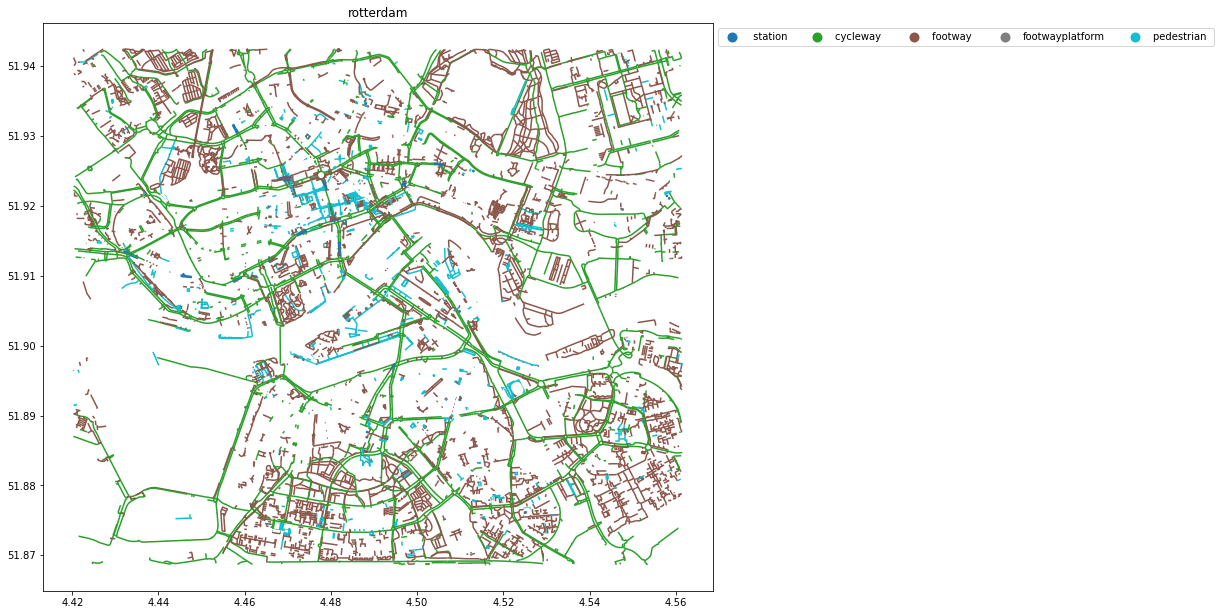

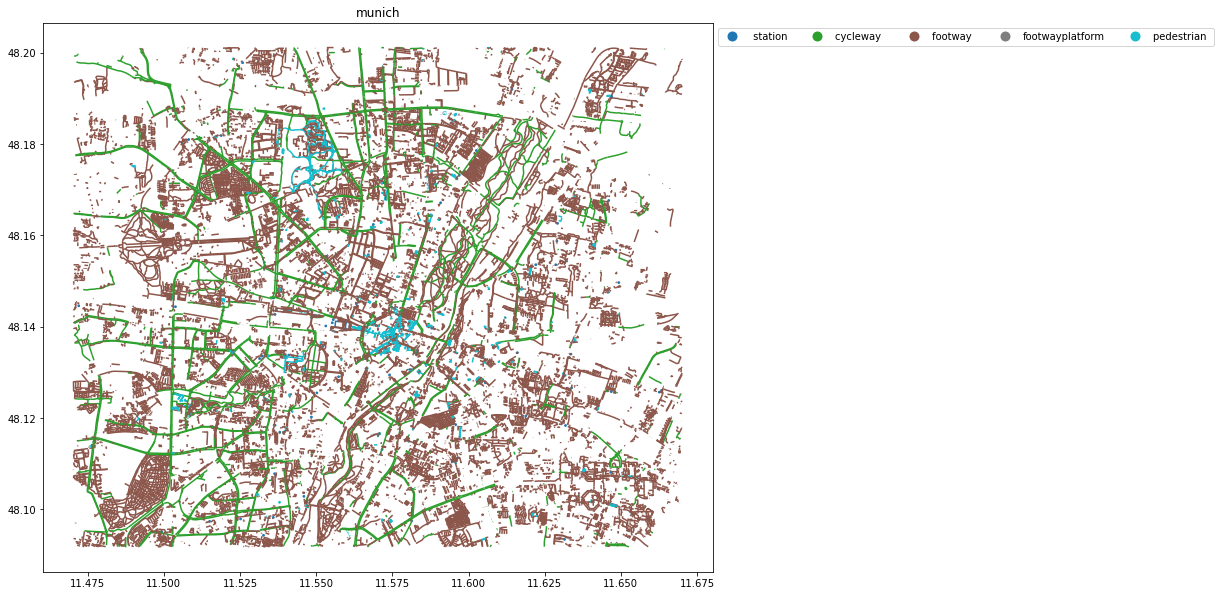

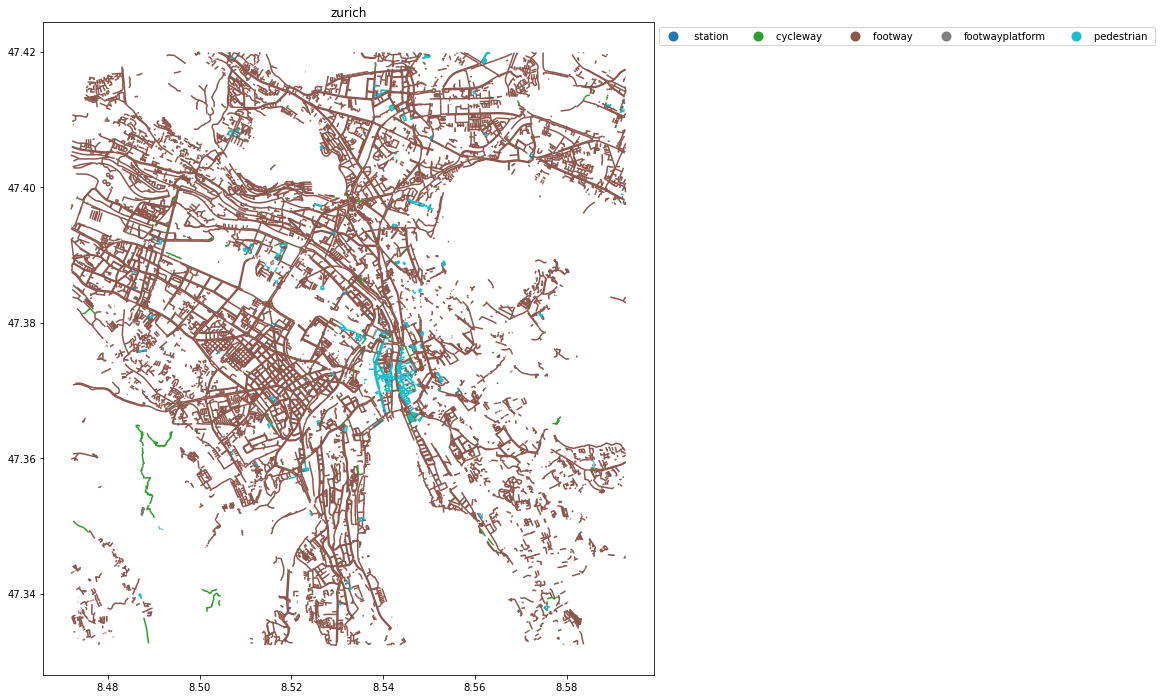

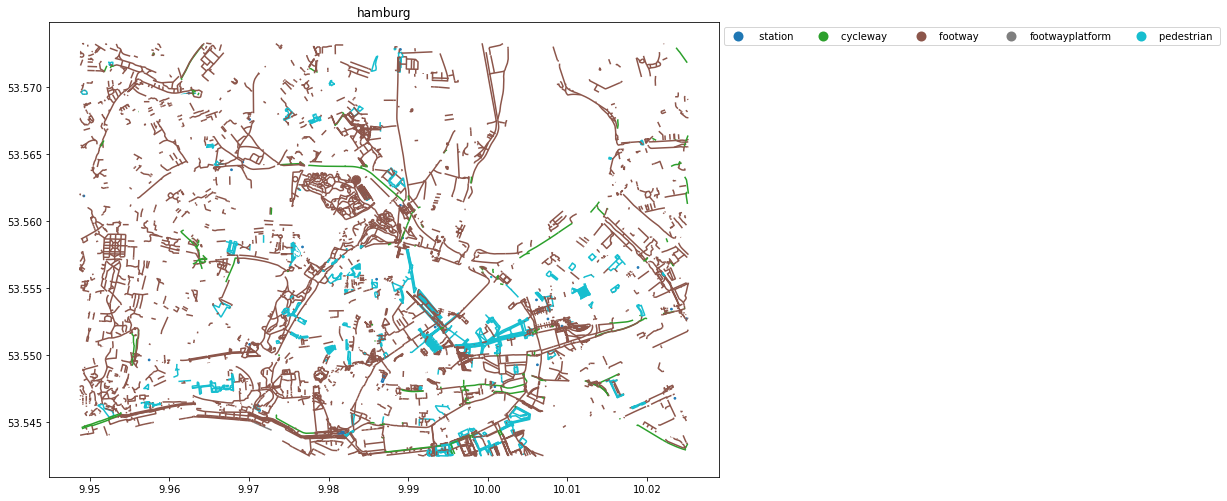

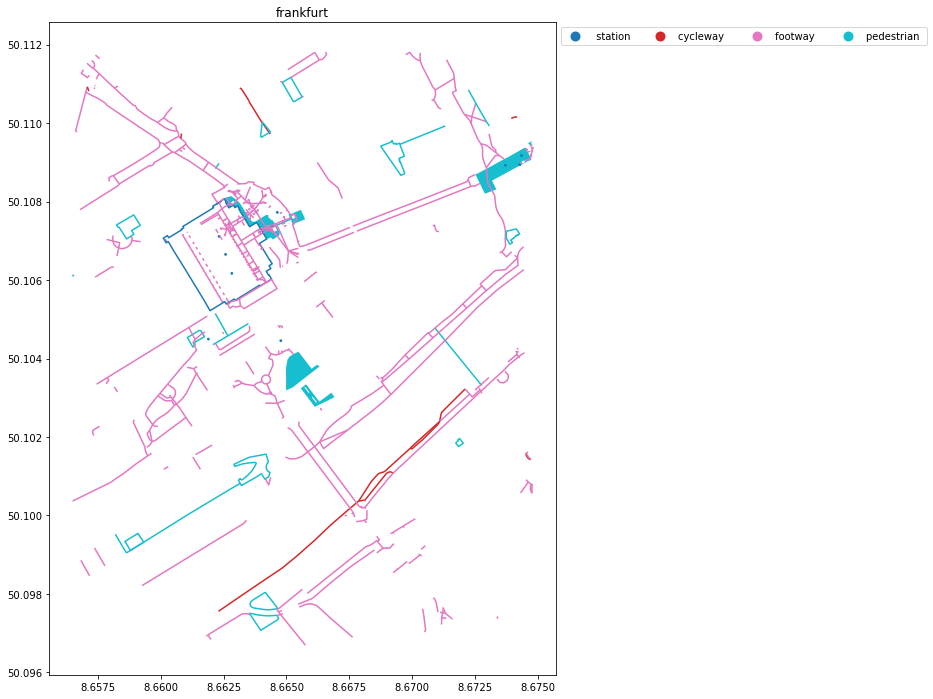

In [5]:
#alternative transport options
PoisDic = dict()
for i,v in [(fp_rotterdam, 'rotterdam'), (fp_munich, 'munich') , (fp_zurich, 'zurich'), (fp_hamburg, 'hamburg'), (fp_frankfurt, 'frankfurt')]:    # Initiliaze with bounding box
    osm = py.OSM(filepath=i)

    # By default pyrosm reads all elements having "amenity", "shop" or "tourism" tag
    # Here, let's read only "amenity" and "shop" by applying a custom filter that
    # overrides the default filtering mechanism
    custom_filter = {'public_transport': ['station'], 'highway': ['pedestrian', 'footway', 'cycleway', 'busway']}
    pois = osm.get_pois(custom_filter=custom_filter)

    # Gather info about POI type (combines the tag info from "amenity" and "shop")
    pois["public_transport"] = pois["public_transport"].fillna(" ")
    pois["highway"] = pois["highway"].fillna(" ")
    pois["poi_type"] = pois["highway"] + pois['public_transport']
    
    # save pois in dict
    PoisDic[v] = pois

    # Plot
    ax = pois.plot(column='poi_type', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))
    ax.set_title(v)
    pois.head()

In [6]:
PoisDic['rotterdam'].head() # stored in dataframe

changeset       lon                                               tags  \
0        0.0  4.558490              {"bus":"yes","amenity":"bus_station"}   
1      -41.0  4.488421  {"bus":"yes","zone":"5175","source":"Arriva","...   
2        0.0  4.480911  {"zone":"5300","subway":"yes","railway":"stati...   
3        0.0  4.458148  {"zone":"5300","subway":"yes","network":"Rail ...   
4        0.0  4.481973  {"zone":"5300","subway":"yes","network":"Rail ...   

           id  version  timestamp        lat addr:country               name  \
0  1889797480        0        -93  51.921089         None  Capelsebrug Metro   
1  2032859196      -45          0  51.887630         None          Zuidplein   
2  3149917961        0          0  51.917953         None              Beurs   
3  3149917962        0          0  51.930611           NL           Blijdorp   
4  3149917967        0          0  51.914028         None         Leuvehaven   

                                  operator  ... service segregated sidewalk  \
0                                     None  ...     NaN        NaN      NaN   
1                                     None  ...     NaN        NaN      NaN   
2  Rotterdamse Elektrische Tram N.V. (RET)  ...     NaN        NaN      NaN   
3                                      RET  ...     NaN        NaN      NaN   
4                                      RET  ...     NaN        NaN      NaN   

  smoothness surface tracktype tunnel width website  poi_type  
0        NaN     NaN       NaN    NaN   NaN     NaN   station  
1        NaN     NaN       NaN    NaN   NaN     NaN   station  
2        NaN     NaN       NaN    NaN   NaN     NaN   station  
3        NaN     NaN       NaN    NaN   NaN     NaN   station  
4        NaN     NaN       NaN    NaN   NaN     NaN   station  

[5 rows x 40 columns]

# Save POI pickle

In [7]:
with open('POI.pickle', 'wb') as handle:
    pickle.dump(PoisDic, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
## Load POI pickle
# Load data (deserialize)
with open('POI.pickle', 'rb') as handle:
    poi_dic = pickle.load(handle)

### Load pickle

In [9]:
# Load data (deserialize)
with open('Edges.pickle', 'rb') as handle:
    dic = pickle.load(handle)

dic['rotterdam'].head()


osmid                     name      highway  \
0  [311806104, 311806106, 321898179]             's-Gravenweg  residential   
1                            7514536       Frans Bekkerstraat  residential   
2                            7515679       Frans Bekkerstraat  residential   
3                 [7515714, 7515628]            Verboomstraat  residential   
4                            7319072  Schultz van Hagenstraat  residential   

   oneway   length bridge                                           geometry  \
0   False   88.311    yes  LINESTRING (4.52452 51.92392, 4.52412 51.92331...   
1   False   61.119    NaN    LINESTRING (4.46527 51.89180, 4.46613 51.89165)   
2   False   76.835    NaN  LINESTRING (4.46527 51.89180, 4.46496 51.89218...   
3   False  145.552    NaN  LINESTRING (4.46527 51.89180, 4.46528 51.89177...   
4   False   48.438    NaN    LINESTRING (4.52872 51.92385, 4.52848 51.92344)   

  maxspeed lanes  ref junction tunnel access         u          v  key detid  
0      NaN   NaN  NaN      NaN    NaN    NaN  44417024  771255062    0   NaN  
1      NaN   NaN  NaN      NaN    NaN    NaN  44269570   44269098    0   NaN  
2       50   NaN  NaN      NaN    NaN    NaN  44269570  963879003    0   NaN  
3       50   NaN  NaN      NaN    NaN    NaN  44269570   44262667    0   NaN  
4      NaN   NaN  NaN      NaN    NaN    NaN  44417028   44412933    0   NaN

### Load flows

In [10]:
data_frankfurt = pd.read_csv('data\\UTD_f.csv')
data_hamburg = pd.read_csv('data/UTD_h.csv')
data_munich = pd.read_csv('data\\UTD_m.csv')
data_rotterdam = pd.read_csv('data\\UTD_r.csv')
data_zurich = pd.read_csv('data\\UTD_z.csv')

In [11]:
frankfurt_detid_average = (data_frankfurt.groupby('detid').flow.mean()).to_frame(name = None)
hamburg_detid_average = (data_hamburg.groupby('detid').flow.mean()).to_frame(name = None)
munich_detid_average = (data_munich.groupby('detid').flow.mean()).to_frame(name = None)
rotterdam_detid_average = (data_rotterdam.groupby('detid').flow.mean()).to_frame(name = None)
zurich_detid_average = (data_zurich.groupby('detid').flow.mean()).to_frame(name = None)

In [12]:
frankfurt_detid_average['city'] = 'frankfurt'
hamburg_detid_average['city'] = 'hamburg'
munich_detid_average['city'] = 'munich'
rotterdam_detid_average['city'] =  'rotterdam'
zurich_detid_average['city'] = 'zurich'

In [13]:
# most Functions dont use this
Mean_perdetid = pd.concat([frankfurt_detid_average,
                                  hamburg_detid_average,
                                  munich_detid_average,
                                  rotterdam_detid_average,
                                  zurich_detid_average])
          

In [14]:
result = Mean_perdetid.to_csv('data\\UTD_Mean_Flow_per_detid.csv', index = True)#exporting data frame as csv file.

In [15]:
MeanFlowDict = {
    'frankfurt':frankfurt_detid_average,
    'hamburg': hamburg_detid_average,
    'munich': munich_detid_average,
    'rotterdam': rotterdam_detid_average,
    'zurich': zurich_detid_average
}

MeanFlowDict['frankfurt']

flow       city
detid                              
BP2_D1         79.481781  frankfurt
BP2_D2        138.109091  frankfurt
BP2_D3        134.057143  frankfurt
BP4_D1(1)     309.166667  frankfurt
BP4_D10(3)    105.637066  frankfurt
...                  ...        ...
T1_D2          60.129496  frankfurt
T1_D3          81.251908  frankfurt
T1_D4         177.875000  frankfurt
WL2_D1(KFZ1)   37.920000  frankfurt
WL2_D2(KFZ3)  102.202247  frankfurt

[112 rows x 2 columns]

### Load flows as edge atributes

In [16]:
# try plotting the flow on the OSMNX graph
hamburg_detid_average.reset_index(inplace = True)
frankfurt_detid_average.reset_index(inplace = True)
munich_detid_average.reset_index(inplace = True)
rotterdam_detid_average.reset_index(inplace = True)
zurich_detid_average.reset_index(inplace = True)

#df['ColumnID'] = df['ColumnID'].astype(str)
munich_detid_average.detid = munich_detid_average.detid.astype(str)

In [17]:
H = dic['hamburg']
def Match(detid, df):
    if type(detid) == str:
        flowval = df.loc[df.detid == detid, 'flow'].values # get specific value
        try:
            flowval = float(flowval) # convert array to float
            return flowval
        except:
            # list empty
            return np.nan
    
    
H['flow'] = H['detid'].apply(Match, args = [hamburg_detid_average])
#H['detid'].apply(Match, args = [hamburg_detid_average])
    

In [18]:
F = dic['frankfurt']
# H = dic['Hamburg'] # skip, allready done
M = dic['munich']
R = dic['rotterdam']
Z = dic['zurich']

F['flow'] = F['detid'].apply(Match, args = [frankfurt_detid_average])
M['flow'] = M['detid'].apply(Match, args = [munich_detid_average])
R['flow'] = R['detid'].apply(Match, args = [rotterdam_detid_average])
Z['flow'] = Z['detid'].apply(Match, args = [zurich_detid_average])
H['flow'] = H['detid'].apply(Match, args = [hamburg_detid_average])


C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

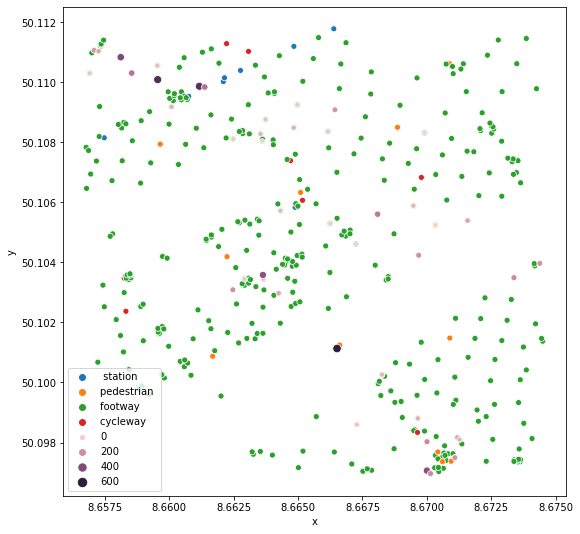

In [19]:
f, ax = plt.subplots(figsize=(9,9))
pois = poi_dic['frankfurt']
pois['x'] = F.geometry.centroid.x
pois['y'] = F.geometry.centroid.y
sns.scatterplot(x = 'x', y = 'y', ax = ax, data = pois, hue = pois['poi_type'].to_list())
F['x'] = F.geometry.centroid.x
F['y'] = F.geometry.centroid.y
flows = sns.scatterplot(x = 'x', y = 'y', ax =ax , data = F, hue = F['flow'].to_list(), size = F['flow'].to_list())
#plt.colorbar(flows)
#ax.legend()

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry i

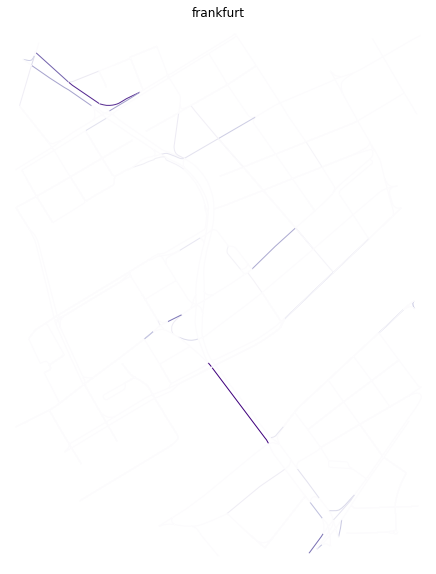

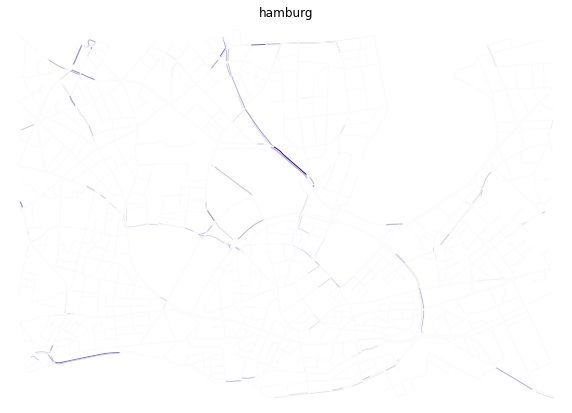

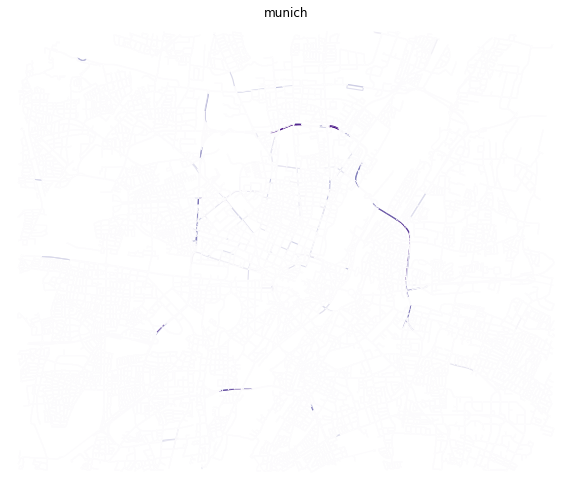

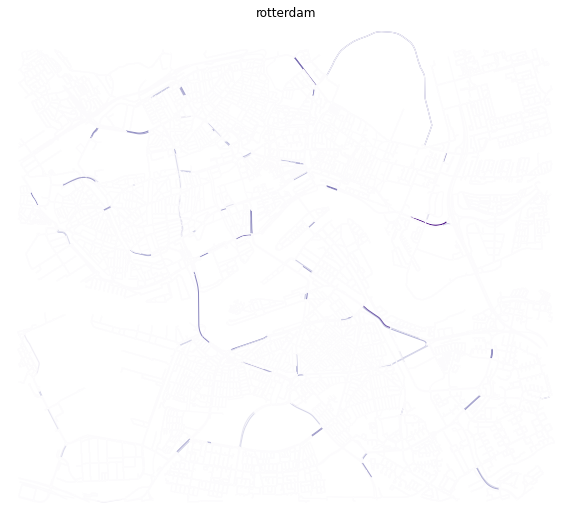

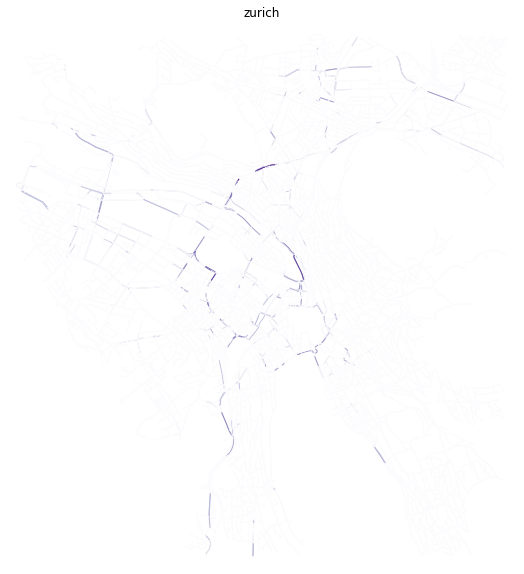

In [20]:
EdgeDict = {'rotterdam':R ,'zurich': Z,'munich':M, 'frankfurt':F, 'hamburg':H}

def CreatePlots(GList, PDict, Clist = UTD19Cities.citycode.unique(), flowdict = EdgeDict): 
    # need to run UTD19Cities, GetGraphs and need the POIS Dic
    for number,city in enumerate(Clist):
        GraphCity = GList[number]
        # plot build enviroment vs traffic flows 
        pois = PDict[city]
        pois['x'] = pois.geometry.centroid.x
        pois['y'] = pois.geometry.centroid.y
        
        N_d, remove = ox.graph_to_gdfs(GraphCity)
        Edge_df = flowdict[city] # retrieve edge data
        Edge_df['flow'] = Edge_df.flow.fillna(0) # necessary for plotting colors
        New = ox.graph_from_gdfs(N_d, Edge_df, graph_attrs={'edge_attr': ['detid', 'flow']} )
        New.graph['crs'] = GraphCity.graph['crs']

        # setup plot
        f, ax = plt.subplots(figsize = (10,10))
        ec = ox.plot.get_edge_colors_by_attr(New, attr='flow', cmap='Purples') # set color scale by atribute (now length could be any other variable)
        z = ox.plot_graph(New, edge_color= ec, node_size=1, ax =ax, show = False, close = False) # edgecolor is stored in ec
        ax.set_title(city)
        # uncomment line below if build enviroment also neccessary
        #sns.scatterplot(x = 'x', y = 'y', ax = ax, data = pois , hue = pois['poi_type'].to_list(), alpha = 0.3, size = 0.3)
 
        
CreatePlots(Graphs, poi_dic)

# Spatial weights (rough)
Example FrankFurt

In [21]:
# retrieve Pois dic
pois = poi_dic['rotterdam']
pois.crs # crs is still in degrees -> reprojection necessary

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
pois = pois.to_crs('EPSG:4839')
pois.crs # worked, now in metres

<Projected CRS: EPSG:4839>
Name: ETRS89 / LCC Germany (N-E)
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Germany - onshore
- bounds: (5.86, 47.27, 15.04, 55.09)
Coordinate Operation:
- name: LCC Germany
- method: Lambert Conic Conformal (2SP)
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [23]:
pois.head()

changeset       lon                                               tags  \
0        0.0  4.558490              {"bus":"yes","amenity":"bus_station"}   
1      -41.0  4.488421  {"bus":"yes","zone":"5175","source":"Arriva","...   
2        0.0  4.480911  {"zone":"5300","subway":"yes","railway":"stati...   
3        0.0  4.458148  {"zone":"5300","subway":"yes","network":"Rail ...   
4        0.0  4.481973  {"zone":"5300","subway":"yes","network":"Rail ...   

           id  version  timestamp        lat addr:country               name  \
0  1889797480        0        -93  51.921089         None  Capelsebrug Metro   
1  2032859196      -45          0  51.887630         None          Zuidplein   
2  3149917961        0          0  51.917953         None              Beurs   
3  3149917962        0          0  51.930611           NL           Blijdorp   
4  3149917967        0          0  51.914028         None         Leuvehaven   

                                  operator  ... sidewalk smoothness surface  \
0                                     None  ...      NaN        NaN     NaN   
1                                     None  ...      NaN        NaN     NaN   
2  Rotterdamse Elektrische Tram N.V. (RET)  ...      NaN        NaN     NaN   
3                                      RET  ...      NaN        NaN     NaN   
4                                      RET  ...      NaN        NaN     NaN   

  tracktype tunnel width website  poi_type         x          y  
0       NaN    NaN   NaN     NaN   station  4.558490  51.921089  
1       NaN    NaN   NaN     NaN   station  4.488421  51.887630  
2       NaN    NaN   NaN     NaN   station  4.480911  51.917953  
3       NaN    NaN   NaN     NaN   station  4.458148  51.930611  
4       NaN    NaN   NaN     NaN   station  4.481973  51.914028  

[5 rows x 42 columns]

In [24]:
from pysal.lib import weights
# get projections in meters
pois['X'] = pois.geometry.centroid.x
pois['Y'] = pois.geometry.centroid.y

# calculate using array, if binary = True -> 1 if neighbour, threshold in meters
%time w = weights.distance.DistanceBand.from_array(pois[['X','Y']], threshold = 250, binary = False) 
w[0] # example of w

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\scipy\sparse\data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
 There are 8 islands with ids: 822, 4009, 4473, 4761, 5140, 7229, 10487, 10996.
  warnings.warn(message)


Wall time: 5.37 s


{11: 0.01839178608095525,
 131: 0.017220133263728798,
 132: 0.008296077472590906,
 133: 0.00998342011302522,
 134: 0.00412763330148496,
 2234: 0.00884542233055942,
 2698: 0.005266792547934974,
 2699: 0.007015757431208713,
 2700: 0.015024489587532976,
 3253: 0.004158132658087155,
 3619: 0.0043762184348743105,
 3654: 0.004913300436297736,
 3655: 0.004045065752296231,
 3659: 0.004712563811246328,
 3661: 0.009456407646686519,
 3663: 0.010371687424561054,
 3664: 0.004325040521268177,
 3665: 0.004278947110497261,
 3666: 0.005175651051532863,
 3667: 0.00424441209302808,
 3668: 0.004093388641434571,
 3781: 0.01060184388208958,
 5135: 0.0045854919710138125,
 5137: 0.004480704061482492,
 6927: 0.0044783792056809915,
 8394: 0.00628584017738901,
 8395: 0.005713309164201774}

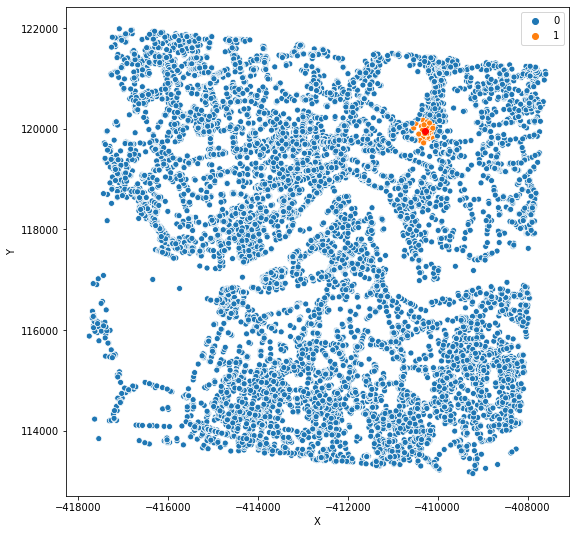

In [25]:
# Validation of W
# Setup figure
f, ax = plt.subplots(1, figsize=(9, 9))
# get neighbours
neis = w[300]
pois['neis'] = 0

for key in neis.keys():
    pois.loc[key,'neis'] = 1 # if neighbour is 1, otherwise 0 
# Plot base layer of polygons
sns.scatterplot(x= 'X', y = 'Y', ax=ax, data = pois, hue = pois['neis'].to_list())
# get first one -> plot in red
data = pois.iloc[300][['X','Y']]
ax.scatter(data.X, data.Y, color = 'red')

# DBSCAN

In [26]:
# retrieve Pois dic
pois = poi_dic['rotterdam']
pois.crs # crs is still in degrees -> reprojection necessary

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [27]:
# need to go te meters
pois = pois.to_crs('EPSG:4839')
pois.crs # worked, now in metres

<Projected CRS: EPSG:4839>
Name: ETRS89 / LCC Germany (N-E)
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Germany - onshore
- bounds: (5.86, 47.27, 15.04, 55.09)
Coordinate Operation:
- name: LCC Germany
- method: Lambert Conic Conformal (2SP)
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:xlabel='X', ylabel='Y'>

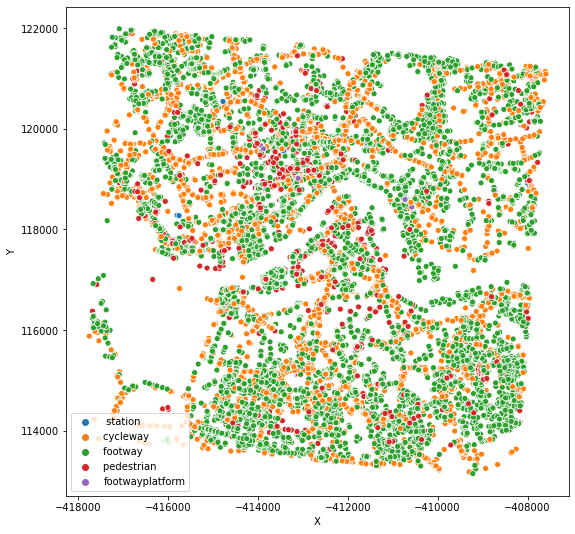

In [28]:
pois['X'] = pois.geometry.centroid.x # calculate x and y in metres
pois['Y'] = pois.geometry.centroid.y

# plot to show it worked
f, ax = plt.subplots(figsize = (9,9))
sns.scatterplot('X', 'Y', data = pois, ax=ax, hue = pois['poi_type'].to_list())

In [29]:
# run DB scan
from sklearn.cluster import DBSCAN
algo = DBSCAN(eps=300, min_samples=50) # eps = 100 m, samples 50

# fit
algo.fit(pois[["X", "Y"]])

DBSCAN(eps=300, min_samples=50)

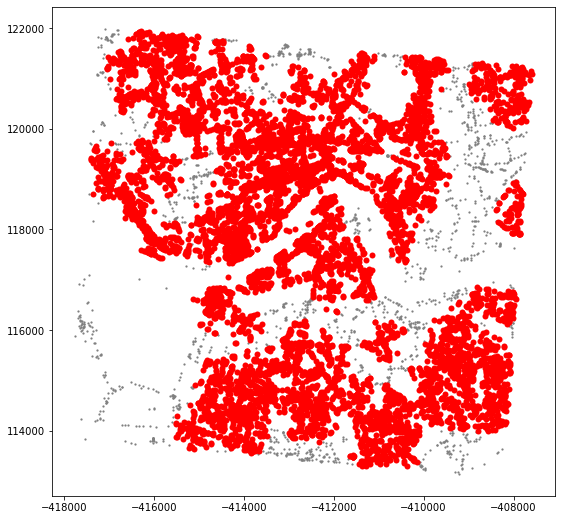

In [30]:
lbls = pd.Series(algo.labels_, index=pois.index)

# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Assign labels to tokyo table dynamically and
# subset points that are not part of any cluster (noise)
noise = pois.assign(lbls=lbls)\
             .query("lbls == -1")
# Plot noise in grey
ax.scatter(noise["X"], 
           noise["Y"], 
           c='grey', 
           s=5, 
           linewidth=0
          )
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(pois.loc[pois.index.difference(noise.index), 
                     "X"
                    ], 
           pois.loc[pois.index.difference(noise.index), 
                     "Y"
                    ],
           c="red", 
           linewidth=0
          )
# Display the figure
plt.show()



In [31]:
pois['labels'] = lbls
# add labels to main dataframe
pois.head() # works

changeset       lon                                               tags  \
0        0.0  4.558490              {"bus":"yes","amenity":"bus_station"}   
1      -41.0  4.488421  {"bus":"yes","zone":"5175","source":"Arriva","...   
2        0.0  4.480911  {"zone":"5300","subway":"yes","railway":"stati...   
3        0.0  4.458148  {"zone":"5300","subway":"yes","network":"Rail ...   
4        0.0  4.481973  {"zone":"5300","subway":"yes","network":"Rail ...   

           id  version  timestamp        lat addr:country               name  \
0  1889797480        0        -93  51.921089         None  Capelsebrug Metro   
1  2032859196      -45          0  51.887630         None          Zuidplein   
2  3149917961        0          0  51.917953         None              Beurs   
3  3149917962        0          0  51.930611           NL           Blijdorp   
4  3149917967        0          0  51.914028         None         Leuvehaven   

                                  operator  ... tracktype tunnel width  \
0                                     None  ...       NaN    NaN   NaN   
1                                     None  ...       NaN    NaN   NaN   
2  Rotterdamse Elektrische Tram N.V. (RET)  ...       NaN    NaN   NaN   
3                                      RET  ...       NaN    NaN   NaN   
4                                      RET  ...       NaN    NaN   NaN   

  website  poi_type         x          y              X              Y labels  
0     NaN   station  4.558490  51.921089 -407969.115106  118874.497908      3  
1     NaN   station  4.488421  51.887630 -413073.438120  115558.422116      0  
2     NaN   station  4.480911  51.917953 -413312.694698  118960.316297      1  
3     NaN   station  4.458148  51.930611 -414756.743713  120490.850901      1  
4     NaN   station  4.481973  51.914028 -413275.614330  118519.433943      1  

[5 rows x 45 columns]

<AxesSubplot:xlabel='X', ylabel='Y'>

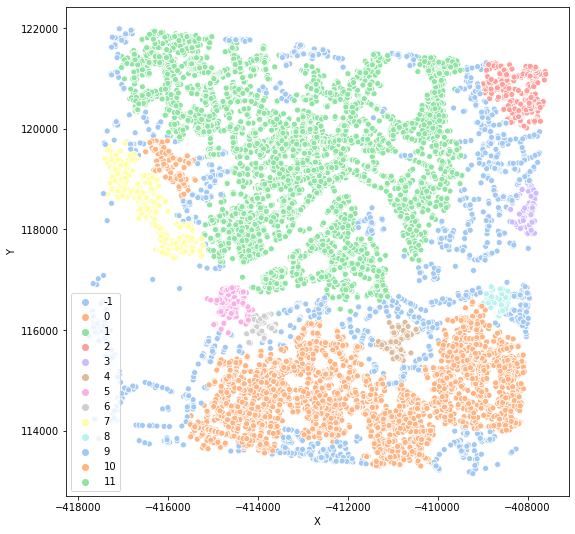

In [32]:
f, ax = plt.subplots(figsize = (9,9))
sns.scatterplot('X', 'Y', data = pois, ax=ax, hue = pois['labels'].to_list(), palette=('pastel'))

In [33]:
# try grouping by
TypeInCluster = pois.groupby('labels').poi_type.unique()

In [34]:
TypeInCluster # see roughly what is in each cluster

labels
-1     [ station, cycleway , footway , pedestrian , f...
 0          [ station, cycleway , footway , pedestrian ]
 1     [ station, cycleway , footway , pedestrian , f...
 2          [ station, cycleway , footway , pedestrian ]
 3                       [ station, cycleway , footway ]
 4                    [cycleway , footway , pedestrian ]
 5                    [footway , cycleway , pedestrian ]
 6                    [cycleway , footway , pedestrian ]
 7          [cycleway , footway , pedestrian ,  station]
 8                    [cycleway , footway , pedestrian ]
 9                    [cycleway , footway , pedestrian ]
 10                   [cycleway , footway , pedestrian ]
 11                   [footway , cycleway , pedestrian ]
Name: poi_type, dtype: object

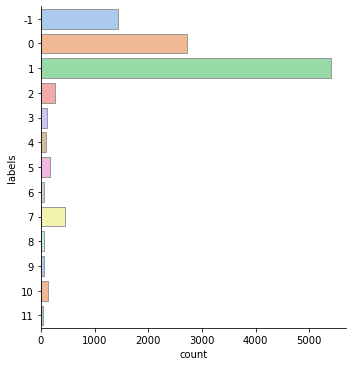

In [35]:
# try a plot?
# few areas with smaller clusters
sns.catplot(y="labels", kind="count",
            palette="pastel", edgecolor=".6",
            data=pois)

In [36]:
# how to link flows with clusters?
# what are the properties of each cluster? -> being close to each other/

# idea; get detector data
RotterdamDet = gpd.GeoDataFrame(UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam'])

# call match -> link flow to det id and long lat        
RotterdamDet['flow'] = RotterdamDet.detid.apply(Match, args = [rotterdam_detid_average])
RotterdamDet.head() # works :)


detid    length       pos     fclass  \
16321  GRT02_MORO_1811_2_1  0.373911  0.307366  secondary   
16322  GRT02_MORO_1822_2_1  1.041926  0.533046  secondary   
16323  GRT02_MORO_1293_2_1  0.168822  0.074032  secondary   
16324  GRT02_MORO_1293_2_2  0.168822  0.074032  secondary   
16325  GRT02_MORO_1851_2_1  0.589675  0.148455      trunk   

                          road limit   citycode  lanes  linkid      long  \
16321          Kreekhuizenlaan    50  rotterdam    1.0   100.0  4.539146   
16322  Groeninx van Zoelenlaan    80  rotterdam    1.0    90.0  4.561430   
16323                Schiekade    50  rotterdam    1.0    47.0  4.475207   
16324                Schiekade    50  rotterdam    1.0    47.0  4.475207   
16325                  Vaanweg    50  rotterdam    1.0    96.0  4.512462   

             lat        flow  
16321  51.884051  392.931968  
16322  51.884623  339.342356  
16323  51.927265  385.277249  
16324  51.927265  280.088515  
16325  51.874034  342.891002

In [37]:
#df2_gdf = geopandas.GeoDataFrame(
#    df2, geometry=geopandas.points_from_xy(df2.long, df2.lat))
RotterdamDet['geometry'] = gpd.points_from_xy(RotterdamDet.long, RotterdamDet.lat)

In [38]:
RotterdamDet.crs = 'EPSG:4326'
RotterdamDet = RotterdamDet.to_crs('EPSG:4839')

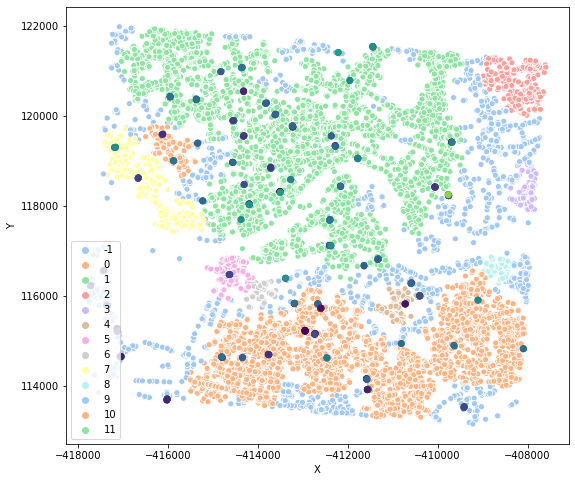

In [39]:
f, ax = plt.subplots(figsize = (9,9))
sns.scatterplot('X', 'Y', data = pois, ax=ax, hue = pois['labels'].to_list(), palette=('pastel'))
# for scatter make RotterdamDet to meter projection
z = RotterdamDet.plot('flow', cmap = 'viridis', ax=ax)
#plt.colorbar(z)

# Calculate Spatial lag

In [40]:
# need to combine data of two data frames
# first RotterdamDet
RotterdamDet = gpd.GeoDataFrame(UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam']) # get from detectors
# call match -> link flow to det id and long lat         get flows
RotterdamDet['flow'] = RotterdamDet.detid.apply(Match, args = [rotterdam_detid_average])
RotterdamDet['geometry'] = gpd.points_from_xy(RotterdamDet.long, RotterdamDet.lat) # get point in 

# need to set a crs
RotterdamDet.crs = 'EPSG:4326' # original (in decimal)
# change to
RotterdamDet = RotterdamDet.to_crs('EPSG:4839') # in metres
RotterdamDet['X'] = RotterdamDet.geometry.centroid.x # calculate x and y in metres
RotterdamDet['Y'] = RotterdamDet.geometry.centroid.y
RotterdamDet=RotterdamDet.loc[:,['detid','X','Y','flow']] # keep only these
RotterdamDet=RotterdamDet.rename(columns={'detid':'id'})
RotterdamDet.reset_index(inplace=True, drop=True)

RotterdamDet.head() # data frame with detector id, coordinates(in metres) and flows! 

id              X              Y        flow
0  GRT02_MORO_1811_2_1 -409627.897334  114878.047007  392.931968
1  GRT02_MORO_1822_2_1 -408094.755561  114817.516243  339.342356
2  GRT02_MORO_1293_2_1 -413618.789295  120024.076884  385.277249
3  GRT02_MORO_1293_2_2 -413618.789295  120024.076884  280.088515
4  GRT02_MORO_1851_2_1 -411548.145144  113917.159526  342.891002

In [41]:
# make pois correct
pois = poi_dic['rotterdam'][['id', 'geometry']] # import only geometry for now
# get x and y
pois['geometry'] = pois.geometry.to_crs('EPSG:4839') # to metres
pois['X'] = pois.geometry.centroid.x
pois['Y'] = pois.geometry.centroid.y
pois.drop('geometry', axis = 1, inplace = True)
#pois=gpd.GeoDataFrame(pois[['id','geometry']]) # keep only relevant data for now

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [42]:
pois.head () # ids with X and Y in metres!

id              X              Y
0  1889797480 -407969.115106  118874.497908
1  2032859196 -413073.438120  115558.422116
2  3149917961 -413312.694698  118960.316297
3  3149917962 -414756.743713  120490.850901
4  3149917967 -413275.614330  118519.433943

In [43]:
pois_and_detec=pois.append(RotterdamDet, ignore_index=True) # poi + detector in dataframe
pois_and_detec

id              X              Y        flow
0               1889797480 -407969.115106  118874.497908         NaN
1               2032859196 -413073.438120  115558.422116         NaN
2               3149917961 -413312.694698  118960.316297         NaN
3               3149917962 -414756.743713  120490.850901         NaN
4               3149917967 -413275.614330  118519.433943         NaN
...                    ...            ...            ...         ...
11252  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149
11253  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754
11254  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099
11255  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881
11256  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421

[11257 rows x 4 columns]

In [44]:
# magic time 
# ensure that crs is in metres!!!!
from pysal.lib import weights # import weight lib
R = weights.distance.DistanceBand.from_array(RotterdamDet[['X','Y']], threshold = 500, binary = True) # spatial weight Rotterdam
R.transform = 'R' # row standardise
RotterdamDet['lag'] = weights.lag_spatial(R, RotterdamDet['flow']) # calculate spatial lag
RotterdamDet.head() # lag is avarge flow of neighbours

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 46 disconnected components.
  warnings.warn(message)


id              X              Y        flow         lag
0  GRT02_MORO_1811_2_1 -409627.897334  114878.047007  392.931968  352.676664
1  GRT02_MORO_1822_2_1 -408094.755561  114817.516243  339.342356  340.167520
2  GRT02_MORO_1293_2_1 -413618.789295  120024.076884  385.277249  227.864533
3  GRT02_MORO_1293_2_2 -413618.789295  120024.076884  280.088515  227.864533
4  GRT02_MORO_1851_2_1 -411548.145144  113917.159526  342.891002  229.296342

<AxesSubplot:xlabel='flow', ylabel='lag'>

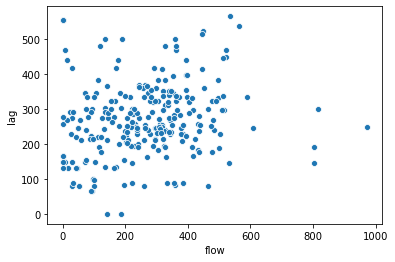

In [45]:
sns.scatterplot(x = 'flow', y = 'lag', data = RotterdamDet) # shows relation of detectors

In [46]:
# need geometries for operation below
pois_and_detec['geometry'] = gpd.points_from_xy(pois_and_detec['X'], pois_and_detec['Y']) # calculate geometrues
z = weights.distance.DistanceBand.from_dataframe(pois_and_detec, threshold =500, ids='id') # get neighbours of points and detectors
#z['GRT02_MORO_1811_2_1'] # neighbours of this point is for example like this

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 495617279, 9927671035.
  warnings.warn(message)


In [47]:
new = {} # create empty dict
for i in pois_and_detec.id: # loop through points and detectors
    x = dict(z[i]) # transorm to dict
    f = {} # intialize nested dict
    for j in x.keys(): # loop through kets
        if type(j) == str: # if key is string it is a detector
            f[j] = 1 # add that it is a neighbour -> 1
    if bool(f) == True: # if not empty
        AmountOfNeis = len(f.values()) # count how much detector neighbours
        for key in f.keys():
            f[key] = (1/AmountOfNeis) # row standardise
    new[i] = f # create nested dic
    

#new # weights of only detectors taken into account -> un # if want to check

In [48]:
# now calculate flowsfor points
def SpatialLag(dic, df):
    df['LagFlow'] = np.nan
    for key in dic.keys():
        spatial = []
        #flow = df.loc[df['id'] == key, 'flow']
        if bool(dic[key]) == True: # dic is not empty
            z = dic[key]
            for detid in z.keys():
               #detid
                flow = df.loc[df.id == detid, 'flow'].values # flow of detid
                weight = z[detid] # WEIGHT
                spat = flow*weight # spatial thing
                spat = float(spat)
                spatial.append(spat)
            
            df.loc[df.id == key, 'LagFlow'] = sum(spatial)            
    return df
        
        
        
s = SpatialLag(new, pois_and_detec)
s

id              X              Y        flow  \
0               1889797480 -407969.115106  118874.497908         NaN   
1               2032859196 -413073.438120  115558.422116         NaN   
2               3149917961 -413312.694698  118960.316297         NaN   
3               3149917962 -414756.743713  120490.850901         NaN   
4               3149917967 -413275.614330  118519.433943         NaN   
...                    ...            ...            ...         ...   
11252  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149   
11253  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754   
11254  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099   
11255  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881   
11256  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421   

                             geometry     LagFlow  
0      POINT (-407969.115 118874.498)         NaN  
1      POINT (-413073.438 115558.422)  134.560407  
2      POINT (-413312.695 118960.316)  336.157523  
3      POINT (-414756.744 120490.851)  160.204828  
4      POINT (-413275.614 118519.434)  276.345282  
...                               ...         ...  
11252  POINT (-409106.593 115900.975)  513.232626  
11253  POINT (-412158.230 118430.894)  499.160471  
11254  POINT (-412158.230 118430.894)  499.160471  
11255  POINT (-412215.181 121408.128)  564.433065  
11256  POINT (-414307.298 118476.877)  286.948915  

[11257 rows x 6 columns]

In [49]:
# lag flow should be the same as original
s.tail()

id              X              Y        flow  \
11252  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149   
11253  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754   
11254  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099   
11255  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881   
11256  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421   

                             geometry     LagFlow  
11252  POINT (-409106.593 115900.975)  513.232626  
11253  POINT (-412158.230 118430.894)  499.160471  
11254  POINT (-412158.230 118430.894)  499.160471  
11255  POINT (-412215.181 121408.128)  564.433065  
11256  POINT (-414307.298 118476.877)  286.948915

In [50]:
RotterdamDet.tail() # this is the case -> lag == LagFlow for detectors

id              X              Y        flow         lag
254  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149  513.232626
255  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754  499.160471
256  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099  499.160471
257  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881  564.433065
258  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421  286.948915

In [51]:
f = gpd.GeoDataFrame(s) # copy s dataframe (so you dont have to run it agian)

def assignFlow(detid, df): 
    if type(detid) != str: # it is not a detector
        p = df.loc[df.id == detid, 'LagFlow'].values # retrieve lagflow as this is the local flow
        p = float(p) # convert to float
        return p
    else:
        p = df.loc[df.id == detid, 'flow'].values # retrieve the original flow
        p = float(p)
        return p
        
f['flow'] = f.id.apply(assignFlow, args=[f])
f

id              X              Y        flow  \
0               1889797480 -407969.115106  118874.497908         NaN   
1               2032859196 -413073.438120  115558.422116  134.560407   
2               3149917961 -413312.694698  118960.316297  336.157523   
3               3149917962 -414756.743713  120490.850901  160.204828   
4               3149917967 -413275.614330  118519.433943  276.345282   
...                    ...            ...            ...         ...   
11252  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149   
11253  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754   
11254  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099   
11255  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881   
11256  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421   

                             geometry     LagFlow  
0      POINT (-407969.115 118874.498)         NaN  
1      POINT (-413073.438 115558.422)  134.560407  
2      POINT (-413312.695 118960.316)  336.157523  
3      POINT (-414756.744 120490.851)  160.204828  
4      POINT (-413275.614 118519.434)  276.345282  
...                               ...         ...  
11252  POINT (-409106.593 115900.975)  513.232626  
11253  POINT (-412158.230 118430.894)  499.160471  
11254  POINT (-412158.230 118430.894)  499.160471  
11255  POINT (-412215.181 121408.128)  564.433065  
11256  POINT (-414307.298 118476.877)  286.948915  

[11257 rows x 6 columns]

In [52]:
g = f.loc[f.flow.notna() == True] # need to remove nan flows (these are not close enough to detectors)
sub = weights.distance.DistanceBand.from_dataframe(g, threshold =500, ids='id') # calculate spatial lags again now with flows
sub.transform = 'R'
g['NewLag'] = weights.lag_spatial(sub, g['flow']) # calculate spatial
g


C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


id              X              Y        flow  \
1               2032859196 -413073.438120  115558.422116  134.560407   
2               3149917961 -413312.694698  118960.316297  336.157523   
3               3149917962 -414756.743713  120490.850901  160.204828   
4               3149917967 -413275.614330  118519.433943  276.345282   
6               3149917977 -412354.505500  117278.962361  281.233870   
...                    ...            ...            ...         ...   
11252  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149   
11253  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754   
11254  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099   
11255  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881   
11256  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421   

                             geometry     LagFlow      NewLag  
1      POINT (-413073.438 115558.422)  134.560407  150.543258  
2      POINT (-413312.695 118960.316)  336.157523  309.505680  
3      POINT (-414756.744 120490.851)  160.204828  267.492662  
4      POINT (-413275.614 118519.434)  276.345282  316.421827  
6      POINT (-412354.505 117278.962)  281.233870  281.064026  
...                               ...         ...         ...  
11252  POINT (-409106.593 115900.975)  513.232626  479.556545  
11253  POINT (-412158.230 118430.894)  499.160471  390.520604  
11254  POINT (-412158.230 118430.894)  499.160471  390.520604  
11255  POINT (-412215.181 121408.128)  564.433065  541.948810  
11256  POINT (-414307.298 118476.877)  286.948915  265.095846  

[6455 rows x 7 columns]

In [53]:
def fixLag(detid, df):
    if type(detid) == str: # detector -> thus lag is NOT NewLag ( as this also takes POI's into account which is not correct)
        p = df.loc[df.id == detid, 'LagFlow'].values
        p = float(p)
        return p
    else: # else poi -> lag is the NewLag
        p = df.loc[df.id == detid, 'NewLag'].values
        p = float(p)
        return p
    
g['lag'] = g.id.apply(fixLag, args=[g])
g.drop(['geometry', 'LagFlow', 'NewLag'], axis = 1, inplace = True)
g # lag of detectors should be similair to the ones calculated in RotterdamDet

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


id              X              Y        flow  \
1               2032859196 -413073.438120  115558.422116  134.560407   
2               3149917961 -413312.694698  118960.316297  336.157523   
3               3149917962 -414756.743713  120490.850901  160.204828   
4               3149917967 -413275.614330  118519.433943  276.345282   
6               3149917977 -412354.505500  117278.962361  281.233870   
...                    ...            ...            ...         ...   
11252  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149   
11253  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754   
11254  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099   
11255  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881   
11256  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421   

              lag  
1      150.543258  
2      309.505680  
3      267.492662  
4      316.421827  
6      281.064026  
...           ...  
11252  513.232626  
11253  499.160471  
11254  499.160471  
11255  564.433065  
11256  286.948915  

[6455 rows x 5 columns]

In [54]:
RotterdamDet.tail() # that is the case

id              X              Y        flow         lag
254  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149  513.232626
255  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754  499.160471
256  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099  499.160471
257  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881  564.433065
258  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421  286.948915

# Concluding Spatial lag
flow for detectors is the detector network flow

For POI's it is the average of DETECTOR flows that it is neighbours with (could be only one or 20 detector neighbours)
The lag for POI's is the average of its neighbours (inclduing detectors) is that correct? 

In [55]:
def Colors(detid):
    if type(detid) == str: # detector -> 1
        return 'detector'
    else: # else poi -> 0
        return 'poi'
g['C'] = g.id.apply(Colors)
g

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


id              X              Y        flow  \
1               2032859196 -413073.438120  115558.422116  134.560407   
2               3149917961 -413312.694698  118960.316297  336.157523   
3               3149917962 -414756.743713  120490.850901  160.204828   
4               3149917967 -413275.614330  118519.433943  276.345282   
6               3149917977 -412354.505500  117278.962361  281.233870   
...                    ...            ...            ...         ...   
11252  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149   
11253  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754   
11254  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099   
11255  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881   
11256  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421   

              lag         C  
1      150.543258       poi  
2      309.505680       poi  
3      267.492662       poi  
4      316.421827       poi  
6      281.064026       poi  
...           ...       ...  
11252  513.232626  detector  
11253  499.160471  detector  
11254  499.160471  detector  
11255  564.433065  detector  
11256  286.948915  detector  

[6455 rows x 6 columns]

<AxesSubplot:xlabel='flow', ylabel='lag'>

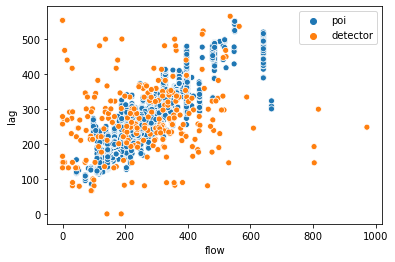

In [56]:
# plot
sns.scatterplot('flow', 'lag', data = g, hue = g['C'].to_list())

<AxesSubplot:xlabel='X', ylabel='Y'>

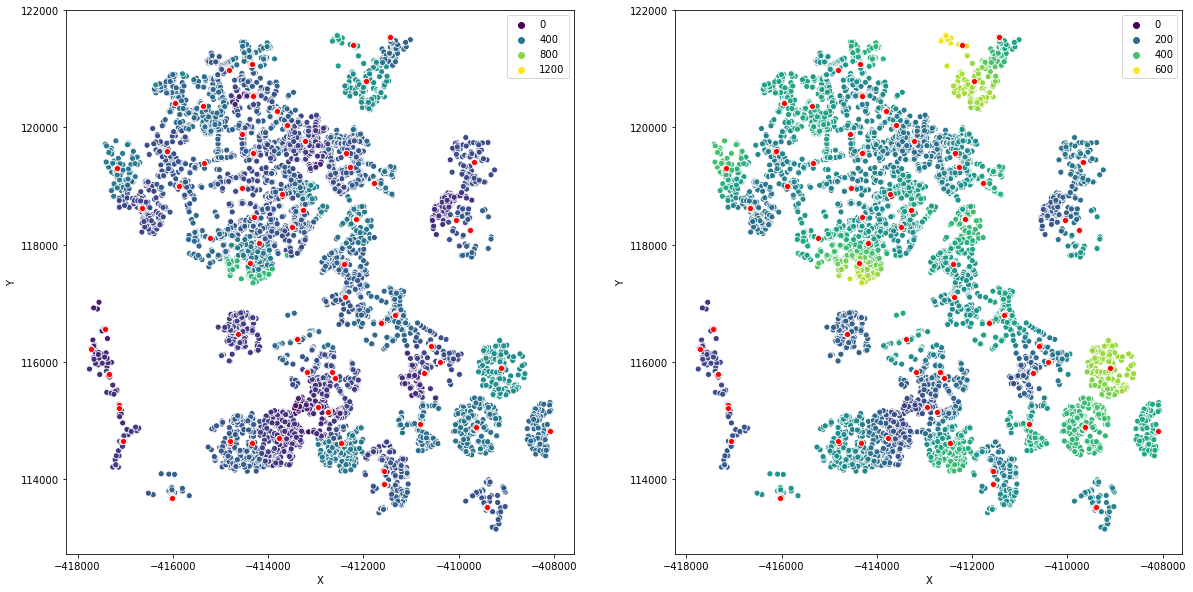

In [57]:
#plotting the guys
f, (ax1, ax2)  = plt.subplots(1,2, figsize = (20,10))
sns.scatterplot('X', 'Y', data = g , ax=ax1, hue = g['flow'].to_list(), palette='viridis') # detectors at their locations check this plz (plot graph underneath?)
sns.scatterplot('X', 'Y', data = RotterdamDet, ax=ax1, color = 'red')

sns.scatterplot('X', 'Y', data = g , ax=ax2, hue = g['lag'].to_list(), palette='viridis')
sns.scatterplot('X', 'Y', data = RotterdamDet, ax=ax2, color = 'red')

# LISA for all cities

Moran's I is: 0.20392749097671473 in frankfurt
Signifcance is 0.001 in frankfurt
Removing 1 detectors without flow, in: hamburg


C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  warnings.warn(message)


Moran's I is: 0.2495820758457843 in hamburg
Signifcance is 0.001 in hamburg


C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 39 disconnected components.
 There is 1 island with id: 10161005.
  warnings.warn(message)
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 38 disconnected components.
  warnings.warn(message)


Removing 1 islands in: munich
Moran's I is: 0.5878366300269721 in munich
Signifcance is 0.001 in munich


C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 46 disconnected components.
  warnings.warn(message)


Moran's I is: 0.09841832934502226 in rotterdam
Signifcance is 0.024 in rotterdam


C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
  warnings.warn(message)


Moran's I is: 0.16077533922670073 in zurich
Signifcance is 0.001 in zurich
Wall time: 1min 17s


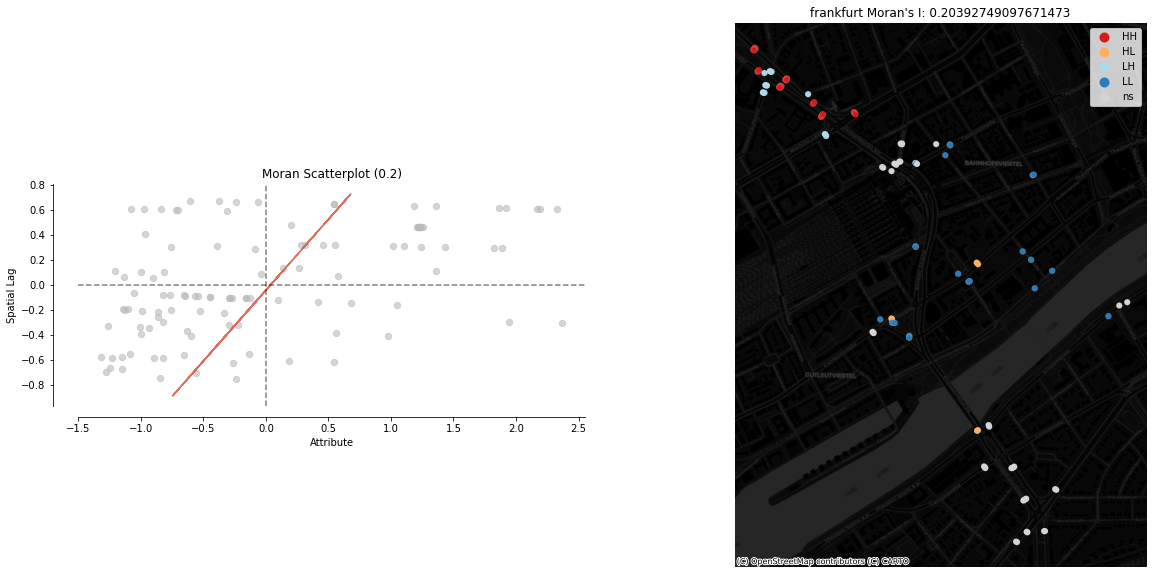

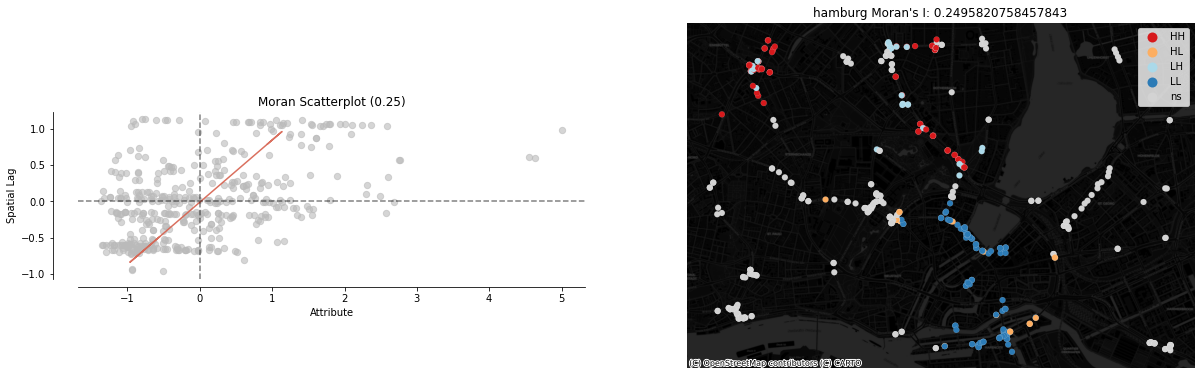

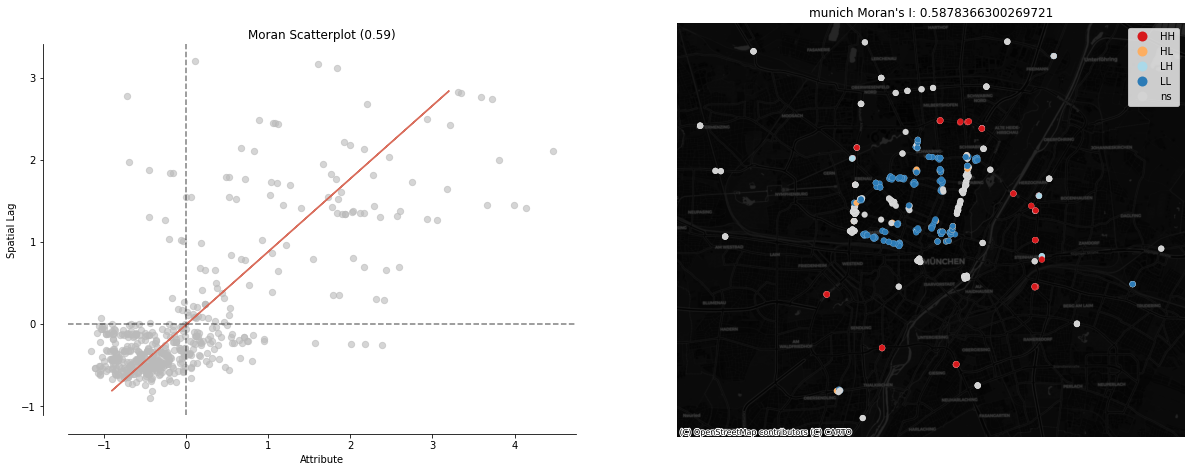

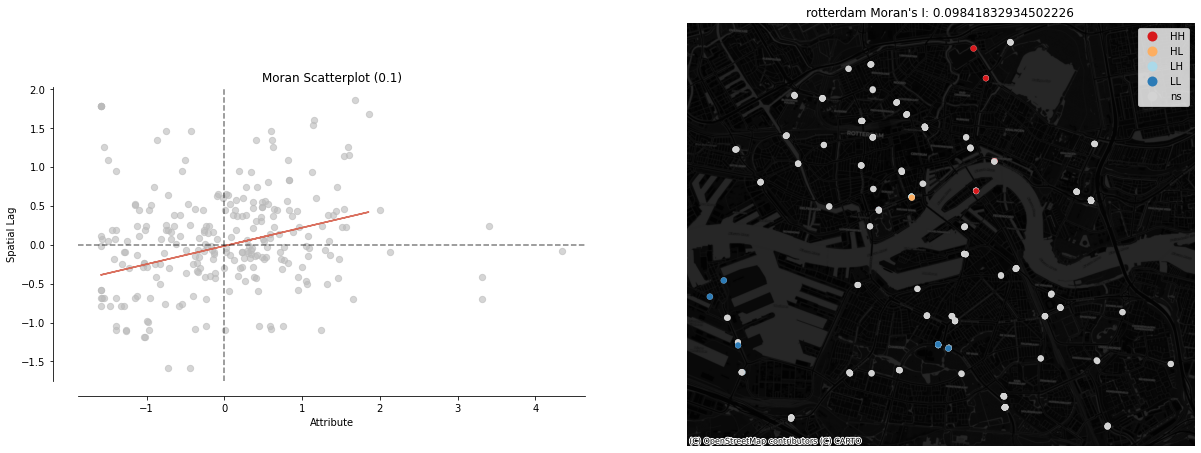

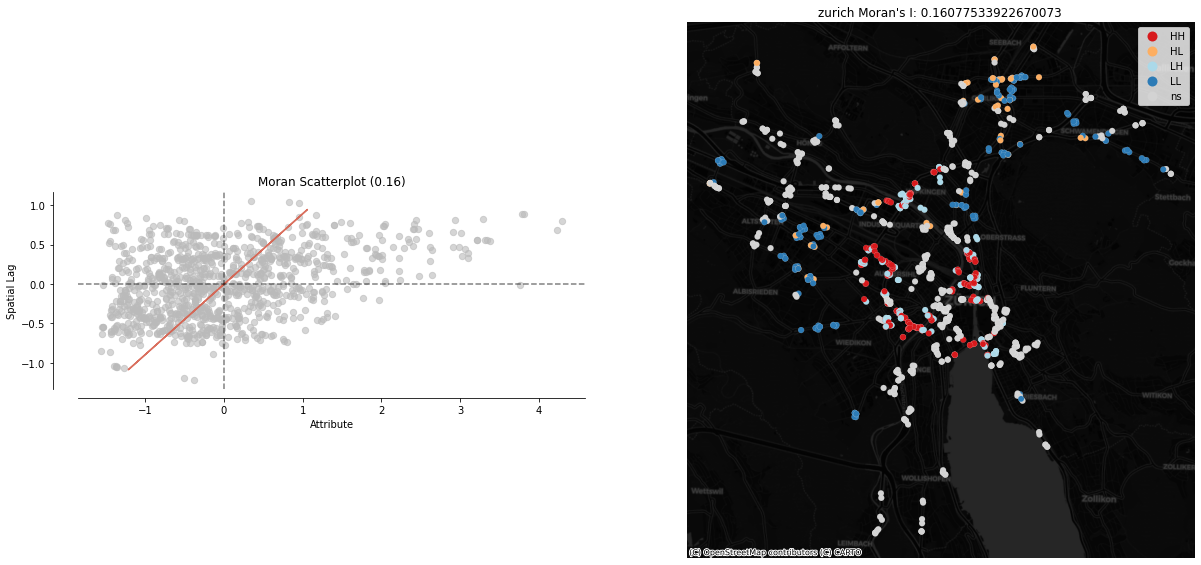

In [58]:
import pysal.explore as pys
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import contextily as cx

def ExploreLisa(thres, df = UTD19Cities, MatchFunc = Match, flowdic = MeanFlowDict):
    citylist = df.citycode.unique()
    for city in citylist:
        # city is the city under check
        Det = gpd.GeoDataFrame(df.loc[df.citycode == city]) # get from detectors
        # get flows for city
        flo = flowdic[city]
        # call match -> link flow to det id and long lat         get flows
        Det['flow'] = Det.detid.apply(MatchFunc, args = [flo])
        
        # remove nans
        if len( Det.loc[Det.flow.isna() == True]) != 0:
            print ('Removing', len( Det.loc[Det.flow.isna() == True]), 'detectors without flow, in:', city)
            Det = Det.loc[Det.flow.notna() == True]
        Det['geometry'] = gpd.points_from_xy(Det.long, Det.lat) # get point in 
        # need to set a crs
        Det.crs = 'EPSG:4326' # original (in decimal)
        # change to
        Det = Det.to_crs('EPSG:4839') # in metres
        Det['X'] = Det.geometry.centroid.x # calculate x and y in metres
        Det['Y'] = Det.geometry.centroid.y
        Det=Det.rename(columns={'detid':'id'})
        # weights 
        W = weights.distance.DistanceBand.from_dataframe(Det, threshold = thres, ids='id')
        
        # exclude Islands
        if bool(W.islands) == True:
            # there are islands remove and recalculate weights
            print ('Removing', len(W.islands), 'islands in:', city)
            for iterator in W.islands:
                Det = Det[Det.id != iterator]
            # with islands removed -> recalc weigths
            W = weights.distance.DistanceBand.from_dataframe(Det, threshold = thres, ids='id')
        
        Det=Det.loc[:,['id','X','Y','flow']] # keep only these

        Det.reset_index(inplace=True, drop=True)
        
        # with detectors now go into LISA
        mi = pys.esda.Moran(Det['flow'], W)
        print ("Moran's I is:",mi.I, 'in', city)
        print ('Signifcance is', mi.p_sim, 'in', city)
        
        try:
            f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
            ax2.set_title(city + ' '+"Moran's I:" + ' '+str(mi.I))
            moran_scatterplot(mi, ax=ax1);
            lisa = pys.esda.Moran_Local(Det['flow'], W)
            # Break observations into significant or not
            Det['significant'] = lisa.p_sim < 0.05
            # Store the quadrant they belong to
            Det['quadrant'] = lisa.q
            #Det.loc[RotterdamDet.significant == True].head()
            Det.geometry = gpd.points_from_xy(Det['X'], Det['Y'])
            

            lisa_cluster(lisa, Det, ax=ax2)
            cx.add_basemap(ax2, crs="EPSG:4839",source=cx.providers.CartoDB.DarkMatter)
        except:
         print('Error: LISA failed in ', city)
        
            

            
            
%time ExploreLisa(500)

In [59]:
UTD19Cities.loc[UTD19Cities.detid == '10161005' ]

detid    length       pos     fclass                road limit  \
16021  10161005  0.295651  0.273033  secondary  Schwanthalerstraße    50   

      citycode  lanes  linkid       long        lat  
16021   munich    1.0    72.0  11.552009  48.137523

In [60]:
deletelist = ['10161005']

In [61]:
#koen.drop(deletelist, columns = 'detid')
#df = df[df.line_race != 0]
#koen[koen.detid != '10161005']

NameError: name 'koen' is not defined

# Moran plot
for detectors first

In [62]:
ls = []
for key in R.neighbors.keys():
    z = len(R.neighbors[key])
    ls.append(z)
np.mean(ls)

5.498069498069498

In [63]:
R.mean_neighbors

5.498069498069498

In [64]:
# need to combine data of two data frames
# first RotterdamDet
RotterdamDet = gpd.GeoDataFrame(UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam']) # get from detectors
# call match -> link flow to det id and long lat         get flows
RotterdamDet['flow'] = RotterdamDet.detid.apply(Match, args = [rotterdam_detid_average])
RotterdamDet['geometry'] = gpd.points_from_xy(RotterdamDet.long, RotterdamDet.lat) # get point in 

# need to set a crs
RotterdamDet.crs = 'EPSG:4326' # original (in decimal)
# change to
RotterdamDet = RotterdamDet.to_crs('EPSG:4839') # in metres
RotterdamDet['X'] = RotterdamDet.geometry.centroid.x # calculate x and y in metres
RotterdamDet['Y'] = RotterdamDet.geometry.centroid.y
RotterdamDet=RotterdamDet.rename(columns={'detid':'id'})
# weights 
R = weights.distance.DistanceBand.from_dataframe(RotterdamDet, threshold=1000, ids='id', binary = True)
RotterdamDet=RotterdamDet.loc[:,['id','X','Y','flow']] # keep only these

RotterdamDet.reset_index(inplace=True, drop=True)

RotterdamDet.head() # data frame with detector id, coordinates(in metres) and flows! 

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  warnings.warn(message)


id              X              Y        flow
0  GRT02_MORO_1811_2_1 -409627.897334  114878.047007  392.931968
1  GRT02_MORO_1822_2_1 -408094.755561  114817.516243  339.342356
2  GRT02_MORO_1293_2_1 -413618.789295  120024.076884  385.277249
3  GRT02_MORO_1293_2_2 -413618.789295  120024.076884  280.088515
4  GRT02_MORO_1851_2_1 -411548.145144  113917.159526  342.891002

In [65]:
# br['Pct_Leave_std'] = (br['Pct_Leave'] - br['Pct_Leave'].mean()) / br['Pct_Leave'].std()
RotterdamDet['flow_std'] = (RotterdamDet['flow'] - RotterdamDet['flow'].mean())/RotterdamDet['flow'].std()
# br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])
RotterdamDet['w_flow_std'] = weights.lag_spatial(R, RotterdamDet['flow_std'])
RotterdamDet


id              X              Y        flow  flow_std  \
0    GRT02_MORO_1811_2_1 -409627.897334  114878.047007  392.931968  0.808909   
1    GRT02_MORO_1822_2_1 -408094.755561  114817.516243  339.342356  0.482613   
2    GRT02_MORO_1293_2_1 -413618.789295  120024.076884  385.277249  0.762301   
3    GRT02_MORO_1293_2_2 -413618.789295  120024.076884  280.088515  0.121827   
4    GRT02_MORO_1851_2_1 -411548.145144  113917.159526  342.891002  0.504220   
..                   ...            ...            ...         ...       ...   
254  GRT02_MORO_1774_2_1 -409106.593117  115900.975177  446.291149  1.133803   
255  GRT02_MORO_1367_2_1 -412158.230191  118430.894223  137.207754 -0.748146   
256  GRT02_MORO_1367_2_2 -412158.230191  118430.894223  358.095099  0.596794   
257  GRT02_MORO_1411_2_1 -412215.181290  121408.127598  535.588881  1.677520   
258  GRT02_MORO_1256_2_1 -414307.298379  118476.877135  216.775421 -0.263674   

     w_flow_std  
0      0.563803  
1      0.487637  
2     -4.731439  
3     -4.731439  
4     -1.874364  
..          ...  
254    1.541397  
255    7.804212  
256    7.804212  
257    6.116038  
258    5.009962  

[259 rows x 6 columns]

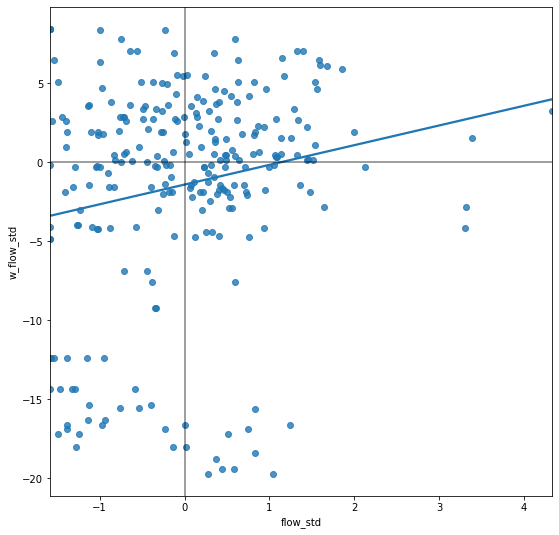

In [66]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='flow_std', y='w_flow_std', data=RotterdamDet, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

# seems to have low correlation

In [67]:
import pysal.explore as idk
mi = idk.esda.Moran(RotterdamDet['flow'], R)
mi.I

0.0976535824483285

In [68]:
mi.p_sim # is significant though

0.004

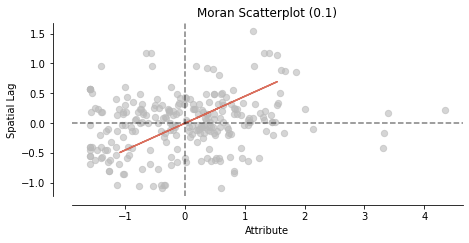

In [69]:
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
moran_scatterplot(mi);

In [70]:
lisa = idk.esda.Moran_Local(RotterdamDet['flow'], R)

# Break observations into significant or not
RotterdamDet['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
RotterdamDet['quadrant'] = lisa.q
RotterdamDet.loc[RotterdamDet.significant == True].head()


RotterdamDet.geometry = gpd.points_from_xy(RotterdamDet['X'], RotterdamDet['Y'])

In [71]:
RotterdamDet.crs

<Projected CRS: EPSG:4839>
Name: ETRS89 / LCC Germany (N-E)
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Germany - onshore
- bounds: (5.86, 47.27, 15.04, 55.09)
Coordinate Operation:
- name: LCC Germany
- method: Lambert Conic Conformal (2SP)
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

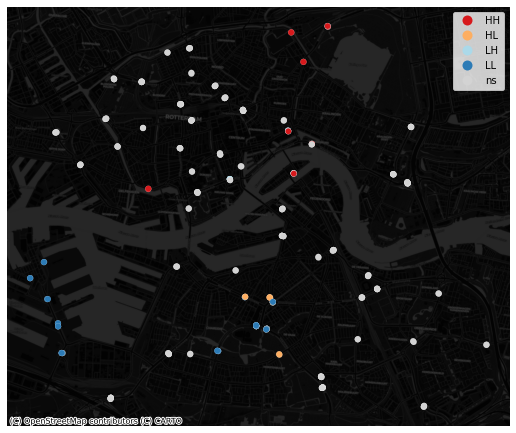

In [121]:
import contextily as cx
f, ax = plt.subplots(figsize = (9,9))
lisa_cluster(lisa, RotterdamDet, ax=ax)
cx.add_basemap(ax, 
               crs="EPSG:4839",
               source=cx.providers.CartoDB.DarkMatter
              )



# Now try for pois to!
For pois -> it doesn't make sense
one step to far :)

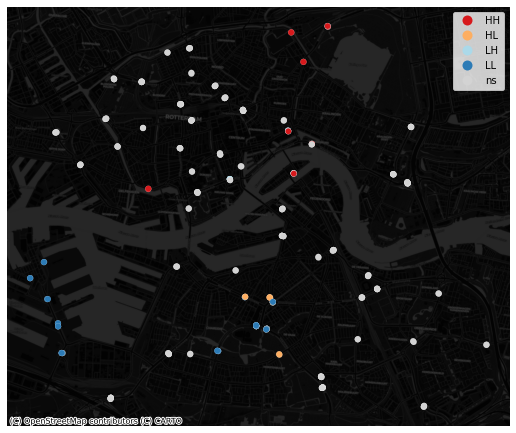

In [73]:
f

In [122]:
g = f.loc[f.flow.notna() == True] # need to remove nan flows (these are not close enough to detectors)
#sub = weights.distance.DistanceBand.from_dataframe(g, threshold =500, ids='id') # calculate spatial lags again now with flows
#sub.transform = 'R'
#g['NewLag'] = weights.lag_spatial(sub, g['flow']) # calculate spatial
func = lambda detid: True if type(detid) == str else False
p = g.loc[g.id.apply(func) == False] # onlt pois
p = p.drop(['LagFlow', 'flow_std'], axis = 1)
p.head()

AttributeError: 'Figure' object has no attribute 'loc'

In [118]:
#sub = weights.distance.DistanceBand.from_dataframe(g, threshold =500, ids='id') # calculate spatial lags again now with flows
#sub.transform = 'R'
#g['NewLag'] = weights.lag_spatial(sub, g['flow']) # calculate spatial

pois_weight = weights.distance.DistanceBand.from_dataframe(p, threshold = 500, ids = 'id')
pois_weight.transform = 'R'
#p['spat_lag'] =  weights.lag_spatial(pois_weight, p['flow']) # calculate spatial
p['flow_std'] = (p['flow'] - p['flow'].mean())/p['flow'].std()
# br['w_Pct_Leave_std'] = weights.lag_spatial(w, br['Pct_Leave_std'])
p['w_flow_std'] = weights.lag_spatial(pois_weight, p['flow_std'])
p

NameError: name 'p' is not defined

NameError: name 'p' is not defined

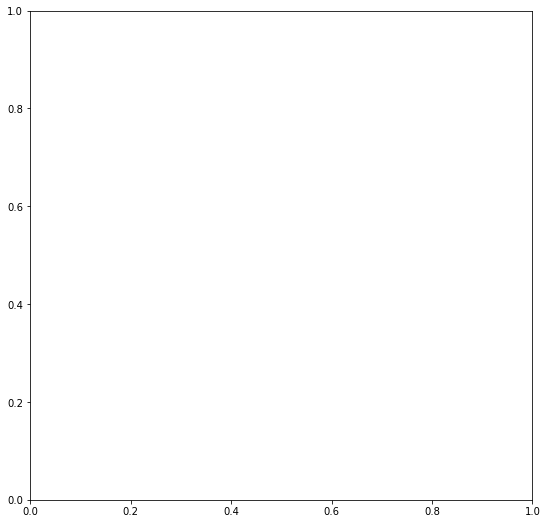

In [119]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='flow_std', y='w_flow_std', data=p, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

In [120]:
mi = idk.esda.Moran(p['flow'], pois_weight)
mi.I

NameError: name 'p' is not defined

In [ ]:
mi.p_sim

In [ ]:
lisa = idk.esda.Moran_Local(p['flow'], pois_weight)

# Break observations into significant or not
p['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
p['quadrant'] = lisa.q
p.loc[p.significant == True].head()

f, ax = plt.subplots(figsize = (9,9))
lisa_cluster(lisa, p, ax=ax);
cx.add_basemap(ax, 
               crs="EPSG:4839",
               source=cx.providers.CartoDB.DarkMatter
              )
#.geometry = gpd.points_from_xy(RotterdamDet['X'], RotterdamDet['Y'])

## Fabian spatial poging (na hier is t een tering zooi :))

In [ ]:
#RotterdamDet = UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam']
RotterdamDet=RotterdamDet.rename(columns={'long':'x','lat':'y'})

In [ ]:
RotterdamDet['X'] = RotterdamDet.geometry.centroid.x # calculate x and y in metres
RotterdamDet['Y'] = RotterdamDet.geometry.centroid.y
RotterdamDet=RotterdamDet.loc[:,['detid','X','Y','flow']]


In [ ]:
RotterdamDet=RotterdamDet.rename(columns={'detid':'id'})

In [ ]:
RotterdamDet.reset_index(inplace=True, drop=True)

In [ ]:
RotterdamDet.crs

In [ ]:
pois = poi_dic['rotterdam']
pois = pois.to_crs('EPSG:4839')

In [ ]:
pois.crs

In [ ]:
pois['X'] = pois.geometry.centroid.x
pois['Y'] = pois.geometry.centroid.y

In [ ]:
pois['flow']=0
pois=gpd.GeoDataFrame(pois[['id','X','Y']])

In [ ]:
type(pois)

In [ ]:
b = RotterdamDet.shape[0]

In [ ]:
print (a+b, pois_and_detec.shape) # Shape klopt

In [ ]:
#works,but too slow...
# w_dict_r={}
# for i,node in enumerate(RotterdamDet.id):
#     pois_node=pois.append(RotterdamDet.iloc[i])
#     w = weights.distance.DistanceBand.from_array(pois[['X','Y']], threshold = 500, binary = False)
#     w_dict_r[node]=w[len(pois_c)-1]
#     print(i)

In [ ]:
pois_and_detec=pois.append(RotterdamDet, ignore_index=True)
#pois_and_detec.iloc[(len(pois)-2):(len(pois)+2)]
#check vanaf welke we willen hebben straks
#pois_and_detec.loc[pois_and_detec.flow.notnull() == True] # heel veel vars zonder flow zijn natuurlijk pois :)
pois_and_detec

In [ ]:
pois_and_detec.crs = 'EPSG:4839'

In [ ]:
pois_and_detec.crs

In [ ]:
%time from pysal.lib import weights

In [ ]:
R = weights.distance.DistanceBand.from_array(RotterdamDet[['X','Y']], threshold = 500, binary = True)
R.transform = 'R'
NeihbourList = []
for i in RotterdamDet.index:
    NeihbourList.append( sum (R[i].values()))
NeihbourList[:4]

In [ ]:
%time RotterdamDet['lag'] = weights.lag_spatial(R, RotterdamDet['flow'])

#br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])

RotterdamDet.tail()

In [ ]:
sns.scatterplot(x = 'flow', y = 'lag', data = RotterdamDet)

In [ ]:
%time w = weights.distance.DistanceBand.from_array(pois_and_detec[['X','Y']], threshold = 500, binary = False)
w.transform = 'R'
#pois_and_detec['lag'] = weights.lag_spatial(w, pois_and_detec['flow'])

In [ ]:
# problem pois have no flow 
# need to assign a flow to pois

# idea: take the spatial weights and flow of detectors closeby; flow is spatially lagged of flows of detectors that are neighbours

# get only the weights of detectors close by?
RotterdamDet['geometry'] = gpd.points_from_xy(RotterdamDet.X, RotterdamDet.Y)
z = weights.distance.DistanceBand.from_dataframe(RotterdamDet, threshold =500, ids='id')
z.transform = 'R'

In [ ]:
z['GRT02_MORO_1293_2_1']

In [ ]:
pois_and_detec['geometry'] = gpd.points_from_xy(pois_and_detec.X, pois_and_detec.Y)
#z = weights.distance.DistanceBand.from_dataframe(pois_and_detec, threshold =500, ids='id')
#z.transform = 'R'

In [ ]:
new = {}
for i in pois_and_detec.id:
    x = dict(z[i])
    f = {}
    for j in x.keys():
        if type(j) == str:
            f[j] = 1
    if bool(f) == True:
        AmountOfNeis = len(f.values())
        for key in f.keys():
            f[key] = (1/AmountOfNeis) # row standardise
    new[i] = f
    

# new is a dict with spatial weights


In [ ]:
#%time ['lag'] = weights.lag_spatial(R, RotterdamDet['flow'])
def SpatialLag(dic, df):
    df['LagFlow'] = np.nan
    for key in dic.keys():
        spatial = []
        #flow = df.loc[df['id'] == key, 'flow']
        if bool(dic[key]) == True: # dic is not empty
            z = dic[key]
            for detid in z.keys():
               #detid
                flow = df.loc[df.id == detid, 'flow'].values # flow of detid
                weight = z[detid] # WEIGHT
                spat = flow*weight # spatial thing
                spat = float(spat)
                spatial.append(spat)
            
            df.loc[df.id == key, 'LagFlow'] = sum(spatial)            
    return df
        
        
        
s = SpatialLag(new, pois_and_detec)

In [ ]:
f = gpd.GeoDataFrame(s)

In [ ]:
f

In [ ]:
def assignFlow(detid, df): 
    if type(detid) != str:
        p = df.loc[df.id == detid, 'LagFlow'].values
        p = float(p)
        return p
    else:
        p = df.loc[df.id == detid, 'flow'].values
        p = float(p)
        return p
        
f['flow'] = f.id.apply(assignFlow, args=[f])

In [ ]:
f

In [ ]:
sub = weights.distance.DistanceBand.from_dataframe(f, threshold =500, ids='id')
sub.transform = 'R'


In [ ]:

g = f.loc[f.flow.notna() == True]
#br['w_Pct_Leave'] = weights.lag_spatial(w, br['Pct_Leave'])
g


In [ ]:
sub = weights.distance.DistanceBand.from_dataframe(g, threshold =500, ids='id')
sub.transform = 'R'
g['NewLag'] = weights.lag_spatial(sub, g['flow'])
g

In [ ]:
def fixLag(detid, df):
    if type(detid) == str:
        p = df.loc[df.id == detid, 'lag'].values
        p = float(p)
        return p
    else:
        p = df.loc[df.id == detid, 'NewLag'].values
        p = float(p)
        return p
    
g['lag'] = g.id.apply(fixLag, args=[g])

In [ ]:
g

In [ ]:
sns.scatterplot(x = 'flow', y = 'lag', data = g)

In [ ]:
Toplot=RotterdamDet
spacial_val=[]   
for j in range (10998,(len(pois_and_detec))):
    spacial_val.append(sum(w[j].values()))
RotterdamDet['spacial_val']=spacial_val

In [ ]:
RotterdamDet.loc[:,'spacial_val']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
#set 2016 as train data
y_train = np.array(RotterdamDet.loc[:,'flow'])
X_train = np.array(RotterdamDet.loc[:,'spacial_val'])
X_train = X_train.reshape(X_train.shape[0], 1)

#set 2017 as test data
y_test = np.array(RotterdamDet.loc[:,'flow'])
X_test = np.array(RotterdamDet.loc[:,'spacial_val'])
X_test = X_test.reshape(X_test.shape[0], 1)

# Check shapes of train and test sets
print('The shape of the x and y train sets are respectively:', X_train.shape, 'and', y_train.shape)

print('The shape of the x and y test value sets are respectively:', X_test.shape,'and', y_test.shape)

#create linear model
regression = LinearRegression()

#fit linear model
regression.fit(X_train, y_train)

predicted_y = regression.predict(X_test)

r2 = regression.score(X_test, y_test)

#print relevant values
print(f'R^2 = {r2:.5}')

print('The regression.score =',regression.score(X_train, y_train))

print('MSE of test values= ',mean_squared_error(predicted_y, y_test))
print('MSE of train values=',mean_squared_error(y_train, regression.predict(X_train)))

print('Coefficients: \n', regression.coef_[0], regression.intercept_)

#start plotting
#two figures, next to each other
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,6.5))

#plot test vs predicted values in left figure
ax1.plot(y_test, predicted_y, 'o')
#set grid limits
grid = np.linspace(np.min(RotterdamDet.loc[:,'flow']), np.max(RotterdamDet.loc[:,'flow']), 100)
ax1.plot(grid, grid, color="black") # add 45 degree line

#set title and labels
ax1.set_xlabel("Actual y", fontsize=20)
ax1.set_ylabel("Predicted y", fontsize=20)
ax1.set_title("Actual vs. predicted values", fontsize=14)

#plot x against y
ax2.plot(RotterdamDet.loc[:,'spacial_val'], RotterdamDet.loc[:,'flow'], 'o')
#set grid limits
xgrid = np.linspace(np.min(RotterdamDet.loc[:,'spacial_val']), np.max(RotterdamDet.loc[:,'spacial_val']), 100)
#plot calculated linear function
ax2.plot(xgrid, regression.predict(xgrid.reshape(100, 1)))

#set title and labels
ax2.set_title("sum spatial weights as predictor for flow", fontsize=14)
ax2.set_ylabel("flow", fontsize=20)
ax2.set_xlabel("Sum spatial weights", fontsize=20)

### count point inside buffer and stuff

#### create geodf with all pois and cities

In [75]:
#unpack poi dic 
Fpois = poi_dic['frankfurt']
Rpois = poi_dic['rotterdam']
Hpois = poi_dic['hamburg']
Mpois = poi_dic['munich']
Zpois = poi_dic['zurich']
    

In [76]:
# addcityname column

Fpois['city'] = 'frankfurt'
Rpois['city'] = 'rotterdam'
Hpois['city'] = 'hamburg'
Mpois['city'] = 'munich'
Zpois['city'] = 'zurich'

In [77]:
# add all to same df
pois_cities = pd.concat([Fpois, Rpois, Hpois, Mpois, Zpois])

In [78]:
pois_cities.columns

Index(['changeset', 'lon', 'tags', 'id', 'version', 'timestamp', 'lat',
       'addr:city', 'addr:postcode', 'addr:street', 'name', 'operator',
       'public_transport', 'station', 'tunnel', 'geometry', 'osm_type',
       'access', 'area', 'bicycle', 'bridge', 'foot', 'footway', 'highway',
       'lit', 'motor_vehicle', 'oneway', 'segregated', 'smoothness', 'surface',
       'width', 'cycleway', 'sidewalk', 'poi_type', 'x', 'y', 'city',
       'addr:country', 'ref', 'junction', 'lanes', 'maxspeed', 'motorcar',
       'service', 'tracktype', 'website', 'opening_hours', 'url',
       'addr:housenumber', 'bicycle_road', 'est_width', 'overtaking', 'psv',
       'path'],
      dtype='object')

#### create geodf with all detectors, flows and cities

In [79]:
UTD19 = pd.read_csv('Data/detectors_public.csv') # read big file with all cities 
newcitylist= [ 'munich', 'rotterdam', 'frankfurt', 'hamburg', 'zurich'] # find only our cities for now, store in dataframe
UTD19Cities = UTD19.loc[UTD19.citycode.isin(newcitylist)] # UTD19Cities is dataframe
df2 = UTD19Cities.loc[UTD19Cities.citycode == 'frankfurt']

In [80]:
Fflow = UTD19Cities.loc[UTD19Cities.citycode == 'frankfurt']
Rflow = UTD19Cities.loc[UTD19Cities.citycode == 'rotterdam']
Hflow = UTD19Cities.loc[UTD19Cities.citycode =='hamburg']
Mflow = UTD19Cities.loc[UTD19Cities.citycode =='munich']
Zflow = UTD19Cities.loc[UTD19Cities.citycode =='zurich']

In [81]:
Fflow['city'] = 'frankfurt'
Rflow['city'] = 'rotterdam'
Hflow['city'] = 'hamburg'
Mflow['city'] = 'munich'
Zflow['city'] = 'zurich'

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [82]:
Fflow['flow'] = Fflow['detid'].apply(Match, args = [frankfurt_detid_average])
Mflow['flow'] = Mflow['detid'].apply(Match, args = [munich_detid_average])
Rflow['flow'] = Rflow['detid'].apply(Match, args = [rotterdam_detid_average])
Zflow['flow'] = Zflow['detid'].apply(Match, args = [zurich_detid_average])
Hflow['flow'] = Hflow['detid'].apply(Match, args = [hamburg_detid_average])

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [83]:
flow_cities = pd.concat([Fflow, Rflow, Mflow, Zflow, Hflow])

In [84]:
flow_cities.head()

detid    length       pos   fclass             road limit  \
3441   STA4_D1(KFZ1)  0.129484  0.039710  primary  Stresemannallee    50   
3442  STA4_D1a(KFZ1)  0.131666  0.041698  primary  Stresemannallee    50   
3443   STA4_D2(KFZ2)  0.131590  0.042400  primary  Stresemannallee    50   
3444  STA4_D2a(KFZ2)  0.077419  0.041444  primary  Stresemannallee    50   
3445  STA4_D8a(KFZ8)  0.254428  0.025927  primary     Kennedyallee    50   

       citycode  lanes  linkid      long        lat       city        flow  
3441  frankfurt    1.0    59.0  8.670011  50.097966  frankfurt  184.139373  
3442  frankfurt    1.0    60.0  8.670057  50.097985  frankfurt  160.647887  
3443  frankfurt    1.0    61.0  8.670108  50.098007  frankfurt  203.034965  
3444  frankfurt    1.0    62.0  8.670148  50.098026  frankfurt  207.872340  
3445  frankfurt    1.0    52.0  8.670210  50.096997  frankfurt  241.062731

#### Create dataframe suitable for analyzing

In [85]:
pois_cities['x'] = pois_cities.geometry.centroid.x
pois_cities['y'] = pois_cities.geometry.centroid.y

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [86]:
flow_cities = gpd.GeoDataFrame(
    flow_cities, geometry=gpd.points_from_xy(flow_cities.long, flow_cities.lat))
flow_cities.set_crs(epsg=4326, inplace=True, allow_override=True)
pois_meters = pois_cities.to_crs(epsg=4839)
flow_meters = flow_cities.to_crs(epsg=4839)

In [87]:
#flow_meters.info()

In [88]:
#pois_meters.info()

#### Functions for counting, clustering and regression

In [89]:
def count_all_pois(pois_df, flow_df):
    flow_df['buffer_500m'] = flow_df.buffer(500)
    joined = gpd.sjoin(pois_df,
                    flow_df.set_geometry('buffer_500m')[['detid', 'buffer_500m']],
                    op="within"
                   )
    poi_count = joined.groupby("detid")["poi_type"].count().to_frame('poi_count')
    flow_pois = flow_df.merge(poi_count, left_on='detid', right_index=True)\
                                 .fillna({"poi_count": 0})
    return flow_pois

poi_counts = count_all_pois(pois_meters, flow_meters)


In [90]:
#poi_counts.info()

<AxesSubplot:xlabel='flow', ylabel='poi_count'>

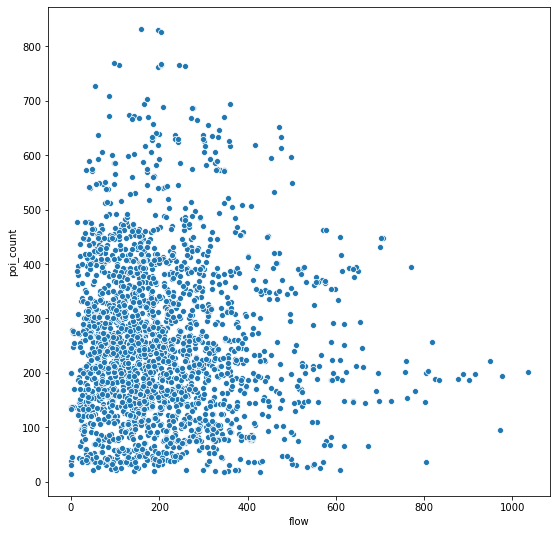

In [91]:
f, ax = plt.subplots(figsize=(9, 9))

sns.scatterplot(x = poi_counts['flow'], y = poi_counts['poi_count'],  ax=ax)

In [92]:
def count_per_poi(pois_df_meters, flow_df_meters, flow_df):
    flow_df['buffer_500m'] = flow_df_meters.buffer(500)
    joined = gpd.sjoin(pois_df_meters,
                    flow_df_meters.set_geometry('buffer_500m')[['detid', 'buffer_500m']],
                    op="within"
                   )
    poi_count_stations = joined.groupby(['detid', 'poi_type'])['poi_type'].count()
    poi_count_stations = poi_count_stations.unstack()
    
    # merge flows with counts per poi
    flow_perpoi = flow_df.merge(poi_count_stations, left_on='detid', right_index=True)
    
    #tidy
    flow_perpoi=flow_perpoi.rename(columns={"pedestrian ": "pedestrian", ' station':'station', 'cycleway ': 'cycleway', 'footway ':'footway'})
    flow_perpoi = flow_perpoi.fillna(value = {"pedestrian": 0, "station" : 0, "cycleway":0, "footway":0})
    
    return flow_perpoi

flow_perpoi = count_per_poi(pois_meters, flow_meters, flow_cities)

In [93]:
flow_perpoi = flow_perpoi[flow_perpoi['flow'].notna()]

In [94]:
var_array = ['station', 'flow', 'cycleway', 'footway', 'pedestrian']
Rflowandpoi=flow_perpoi[flow_perpoi['city']=='rotterdam']

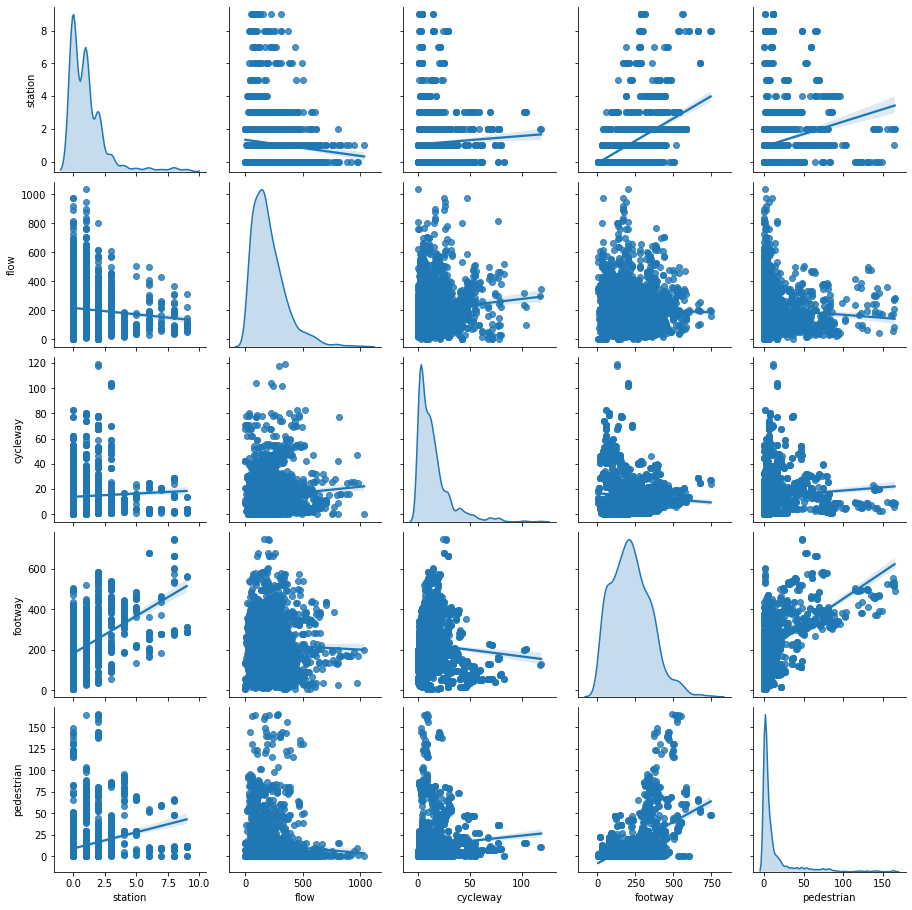

In [161]:
_ = sns.pairplot(flow_perpoi[var_array], kind='reg', diag_kind='kde')

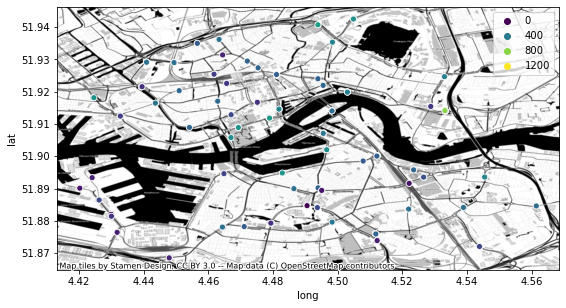

In [116]:
def get_on_map(df_flows_pois, city, column_to_plot):
    f, ax = plt.subplots(1, figsize=(9, 9))
    #df_flows_pois[df_flows_pois['city']== city].plot(column=column_to_plot,
    #                                alpha=0.5,
    #                                legend=True,
    #                                ax=ax
    #                     )
    sns.scatterplot(x = 'long', y = 'lat', ax = ax, data = df_flows_pois[df_flows_pois['city']== city],\
                    hue = df_flows_pois[df_flows_pois['city']== city][column_to_plot].to_list(),\
                    palette = 'viridis')

    
    cx.add_basemap(ax, 
                    crs=df_flows_pois.crs.to_string(), 
                    source=cx.providers.Stamen.Toner,
                    )

    
get_on_map(flow_perpoi, 'rotterdam', 'flow')

In [157]:
def clustering(df, var):
    kmeans4 = cluster.KMeans(n_clusters=4)
    np.random.seed(1234)
    k4cls = kmeans4.fit(df[var])
    df['k4cls'] = k4cls.labels_
    return df

cluster_df = clustering(poi_counts, [''])

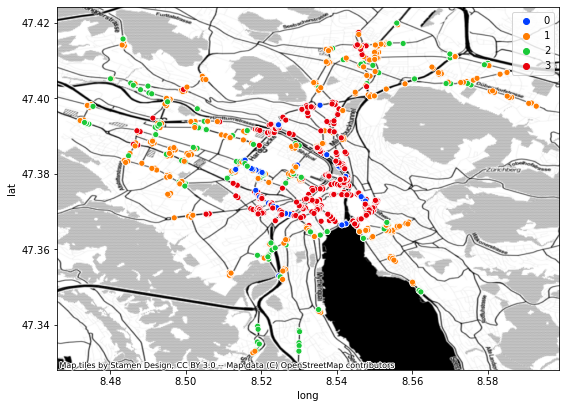

In [159]:
f, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(x = 'long', y = 'lat', ax = ax, data = cluster_df[cluster_df['city']== 'zurich'],\
                hue = cluster_df[cluster_df['city']== 'zurich']['k4cls'].tolist(), palette = 'bright')

cx.add_basemap(ax, 
                      crs=pois_cities.crs.to_string(), 
                       source=cx.providers.Stamen.Toner
                     )

In [160]:
# Calculate the mean by group
k5means = cluster_df.groupby(['k4cls', 'city'])[['station', 'flow', 'cycleway', 'footway','pedestrian']].mean()
# Show the table transposed (so it's not too wide)
k5means#.T

station        flow   cycleway     footway  pedestrian
k4cls city                                                              
0     frankfurt  2.416667  504.135417   3.083333  128.250000    4.416667
      hamburg    2.666667  586.928246  15.333333  349.000000    3.333333
      munich     0.644068  652.415363  16.067797  187.542373    2.762712
      rotterdam  0.333333  559.826759  36.296296   83.370370    5.481481
      zurich     0.958333  525.540670   8.972222  326.250000   13.444444
1     frankfurt  4.170213   99.408079   2.553191  160.319149    6.212766
      hamburg    1.020101  103.226930   6.442211  182.095477   11.839196
      munich     1.037037  114.758204  18.279835  176.897119    5.600823
      rotterdam  0.918605   82.611068  43.686047   73.197674    9.383721
      zurich     0.333333  110.393001   5.398374  184.997290    2.612466
2     frankfurt  1.263158  307.537410   2.973684   92.210526    3.710526
      hamburg    1.138889  269.075797   5.986111  143.666667    5.111111
      munich     0.804878  282.762434  15.105691  152.065041    5.341463
      rotterdam  0.630137  309.184049  43.856164   76.130137   10.547945
      zurich     0.441989  289.063800   5.651934  173.596685    2.679558
3     frankfurt  7.866667  200.686512   3.133333  287.800000   10.466667
      hamburg    2.812500  121.652205  12.895833  367.048611   44.326389
      munich     3.063158  170.245060  27.484211  388.557895   21.673684
      zurich     0.989950  202.750295  12.884422  377.258794   30.854271

In [244]:
def regression(y_array, x_array, df):
    
    # the df is split into a training and testing set
    # the test size is 0.2%, since the df is not very large
    traindf, testdf = train_test_split(df, test_size=0.2, random_state=42)
    print(f'Shape of the training set is {traindf.shape} and of the testing set is {testdf.shape}.')
    print(1)
    # creates arrays for the predicted variable and the prediction variables
    y_train = traindf[y_array]
    x_train = traindf[x_array]

    y_test = testdf[y_array]
    x_test = testdf[x_array]
    print(2)

    #x_train = pd.get_dummies(x_train, columns=['city'])
    #x_test = pd.get_dummies(x_test, columns=['city'])
    #print(3)
    
    # create the X matrix by appending a column of ones to x_train and x_test
    train_data_augmented = sm.add_constant(x_train)
    test_data_augmented = sm.add_constant(x_test)
    print(4)

    # build the OLS model (ordinary least squares) from the training data
    OLS_model = sm.OLS(y_train, train_data_augmented)
    print(5)

    # do the fit and save regression info (parameters, etc) in OLS_results
    OLS_results = OLS_model.fit()
    print(6)
    
    # get the prediction results for the test set
    predy_test = OLS_results.predict(test_data_augmented)
    print(7)
    
    return [OLS_results, y_train, x_train, y_test, x_test, predy_test]

regression_model1, y_train1, x_train1, y_test1, x_test1, predy_test1\
= regression(['flow'], ['station', 'cycleway', 'footway', 'pedestrian', 'city'], flow_perpoi )

Shape of the training set is (1863, 22) and of the testing set is (466, 22).
1
2
4


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [187]:
print(regression_model1.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     17.78
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           8.64e-26
Time:                        15:58:18   Log-Likelihood:                -11844.
No. Observations:                1863   AIC:                         2.371e+04
Df Residuals:                    1854   BIC:                         2.376e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            168.1217      6.433     26.

In [177]:
def linearity_check(x_train, y_train, residuals, predy_train):
    # create plot
    fig, ax = plt.subplots(1,3, figsize=(20,5))

    # create regresion between y and predicted y
    sns.regplot(predy_train, y_train, ax=ax[0])
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')

    # create regression plot with residuals and predicted y
    sns.regplot(predy_train, residuals, ax=ax[1])
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residuals')

    # create kde plot of residuals
    sns.distplot(residuals, ax=ax[2])
    ax[2].set_xlabel('Residuals')
    ax[2].set_ylabel('Density')

    fig.suptitle('Linearity test', fontsize=25)

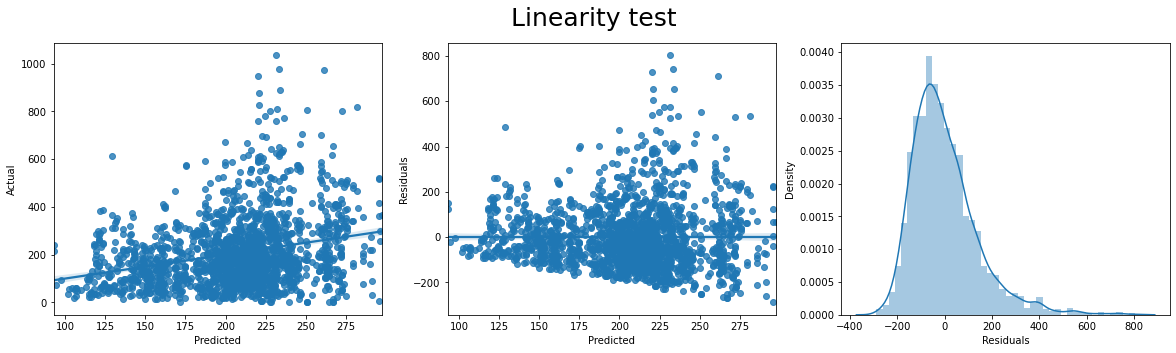

In [178]:
# residual analysis to determine whether assumption of linearity was correct
residuals1 = regression_model1.resid
predy_train1 = regression_model1.fittedvalues
#y_train1 = y_train1.reshape(y_train1.shape[0], )

linearity_check(x_train1, y_train1, residuals1, predy_train1)

In [191]:
print(x_train1.columns)

Index(['station', 'cycleway', 'footway', 'pedestrian', 'city_frankfurt',
       'city_hamburg', 'city_munich', 'city_rotterdam', 'city_zurich'],
      dtype='object')


In [195]:
conditions = [
    x_train1['city_hamburg'] == 1, 
    x_train1['city_munich'] == 1, 
    x_train1['city_rotterdam'] == 1,
    x_train1['city_zurich']  == 1,
    x_train1['city_frankfurt'] == 1
]

outputs = [
    'hamburg', 'munich', 'rotterdam', 'zurich', 'frankfurt'
]

In [200]:
x_train_cities = x_train1[['station', 'cycleway', 'footway', 'pedestrian']]
x_train_cities['city'] = np.select(conditions, outputs, 'Other')
x_train_cities['residual'] = residuals1.values

C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\hanna\Anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


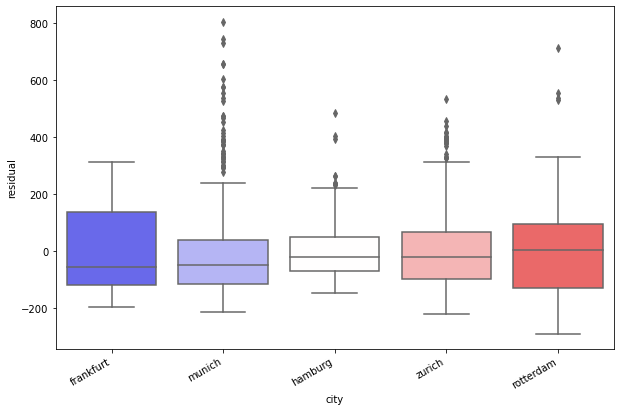

In [203]:


medians = x_train_cities.groupby("city").residual.median().to_frame('city_residual')

f = plt.figure(figsize=(10,7))
ax = plt.gca()
sns.boxplot('city', 'residual', ax = ax,
                data=x_train_cities.merge(medians, how='left',
                              left_on='city',
                              right_index=True)
                   .sort_values('city_residual'), palette='bwr')
f.autofmt_xdate()
plt.show()

In [113]:
import statsmodels.graphics.api as smg
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

In [114]:
def get_teststats(y_test, predy_test):
    r2_score_test = r2_score(y_test, predy_test)
    MAE = mean_absolute_error(y_test, predy_test)
    return r2_score_test, MAE

R2score_model1, MAE_model1 = get_teststats(y_test1, predy_test1)


In [115]:
print(f'R2-score 1: {R2score_model1}')
print(f'MAE 1:{MAE_model1}')

R2-score 1: 0.026444570276013213
MAE 1:116.99196658243702


In [165]:
poi_counts = poi_counts[poi_counts['flow'].notna()]

In [166]:
regression_model2, y_train2, x_train2, y_test2, x_test2, predy_test2\
= regression(['flow'], ['poi_count'], poi_counts )

Shape of the training set is (1863, 16) and of the testing set is (466, 16).


In [167]:
print(regression_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3659
Date:                Sun, 08 Nov 2020   Prob (F-statistic):              0.545
Time:                        14:18:02   Log-Likelihood:                -11912.
No. Observations:                1863   AIC:                         2.383e+04
Df Residuals:                    1861   BIC:                         2.384e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        210.0268      6.859     30.620      0.0

In [ ]:
train_design_recoded = pd.get_dummies(x_train1, columns=['city'], drop_first=True)
test_design_recoded = pd.get_dummies(x_test1, columns=['city'], drop_first=True)


In [222]:
ja = flow_perpoi

In [223]:
ja.head()

detid    length       pos   fclass             road limit  \
3441   STA4_D1(KFZ1)  0.129484  0.039710  primary  Stresemannallee    50   
3442  STA4_D1a(KFZ1)  0.131666  0.041698  primary  Stresemannallee    50   
3443   STA4_D2(KFZ2)  0.131590  0.042400  primary  Stresemannallee    50   
3444  STA4_D2a(KFZ2)  0.077419  0.041444  primary  Stresemannallee    50   
3445  STA4_D8a(KFZ8)  0.254428  0.025927  primary     Kennedyallee    50   

       citycode  lanes  linkid      long  ...        flow  \
3441  frankfurt    1.0    59.0  8.670011  ...  184.139373   
3442  frankfurt    1.0    60.0  8.670057  ...  160.647887   
3443  frankfurt    1.0    61.0  8.670108  ...  203.034965   
3444  frankfurt    1.0    62.0  8.670148  ...  207.872340   
3445  frankfurt    1.0    52.0  8.670210  ...  241.062731   

                      geometry  \
3441  POINT (8.67001 50.09797)   
3442  POINT (8.67006 50.09799)   
3443  POINT (8.67011 50.09801)   
3444  POINT (8.67015 50.09803)   
3445  POINT (8.67021 50.09700)   

                                            buffer_500m station cycleway  \
3441  POLYGON ((-130321.294 -98625.862, -130323.702 ...     0.0      2.0   
3442  POLYGON ((-130317.960 -98623.788, -130320.368 ...     0.0      2.0   
3443  POLYGON ((-130314.256 -98621.490, -130316.663 ...     0.0      2.0   
3444  POLYGON ((-130311.330 -98619.461, -130313.738 ...     0.0      2.0   
3445  POLYGON ((-130309.766 -98733.893, -130312.173 ...     0.0      1.0   

      footway  footwayplatform  pedestrian  k5cls  k4cls  
3441     42.0              NaN         3.0      1      2  
3442     42.0              NaN         3.0      1      1  
3443     42.0              NaN         3.0      1      2  
3444     42.0              NaN         3.0      1      2  
3445     39.0              NaN         2.0      2      2  

[5 rows x 22 columns]

In [224]:
regression_weights = weights.distance.DistanceBand.from_dataframe(ja, threshold = 500, ids = 'detid')


In [225]:
# Row-standardize the queen matrix
regression_weights.transform = 'R'

In [231]:
w_flow = weights.lag_spatial(regression_weights, ja['flow'])


In [232]:
ja = ja[['flow', 'station', 'cycleway', 'footway', 'pedestrian', 'city']]
ja['w_flow'] = w_flow

In [280]:
regression_model3, y_train3, x_train3, y_test3, x_test3, predy_test3\
= regression(['flow'], ['station', 'cycleway', 'footway', 'pedestrian', 'w_flow_2', 'w_flow'], ja)

Shape of the training set is (1863, 13) and of the testing set is (466, 13).
1
2
4
5
6
7


In [281]:
print(regression_model3.summary())

                            OLS Regression Results                            
Dep. Variable:                   flow   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     1209.
Date:                Sun, 08 Nov 2020   Prob (F-statistic):               0.00
Time:                        17:54:20   Log-Likelihood:                -10431.
No. Observations:                1863   AIC:                         2.088e+04
Df Residuals:                    1856   BIC:                         2.091e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.259e+07   4.27e+06     14.669      0.0

In [282]:
R2score_model3, MAE_model3 = get_teststats(y_test3, predy_test3)
print(f'R2-score 1: {R2score_model3}')
print(f'MAE 1:{MAE_model3}')

R2-score 1: 0.7860515173740281
MAE 1:43.29844167679704


In [273]:
ja['station_log'] = np.log(ja['station'].replace(0, np.nan))
ja['cycleway_log'] = np.log(ja['cycleway'].replace(0, np.nan))
ja['footway_log'] = np.log(ja['footway'].replace(0, np.nan))
ja['pedestrian_log'] = np.log(ja['pedestrian'].replace(0, np.nan))
ja['flow_log'] = np.log(ja['flow'].replace(0, np.nan))

# create second degree polynomial
polynomial_features= PolynomialFeatures(degree=2)
poly_constructionyear = polynomial_features.fit_transform(ja[['w_flow']])
ja['w_flow_2'] = pd.DataFrame(poly_constructionyear)[2].values

ja = ja.fillna(0)

In [267]:
ja.head()

flow  station  cycleway  footway  pedestrian       city  \
3441  184.139373      0.0       2.0     42.0         3.0  frankfurt   
3442  160.647887      0.0       2.0     42.0         3.0  frankfurt   
3443  203.034965      0.0       2.0     42.0         3.0  frankfurt   
3444  207.872340      0.0       2.0     42.0         3.0  frankfurt   
3445  241.062731      0.0       1.0     39.0         2.0  frankfurt   

          w_flow  station_log  cycleway_log  footway_log  pedestrian_log  \
3441  206.490709          0.0      0.693147     3.737670        1.098612   
3442  206.500800          0.0      0.693147     3.737670        1.098612   
3443  206.482592          0.0      0.693147     3.737670        1.098612   
3444  206.480514          0.0      0.693147     3.737670        1.098612   
3445  206.466257          0.0      0.000000     3.663562        0.693147   

      flow_log  
3441  5.215693  
3442  5.079215  
3443  5.313378  
3444  5.336924  
3445  5.485057

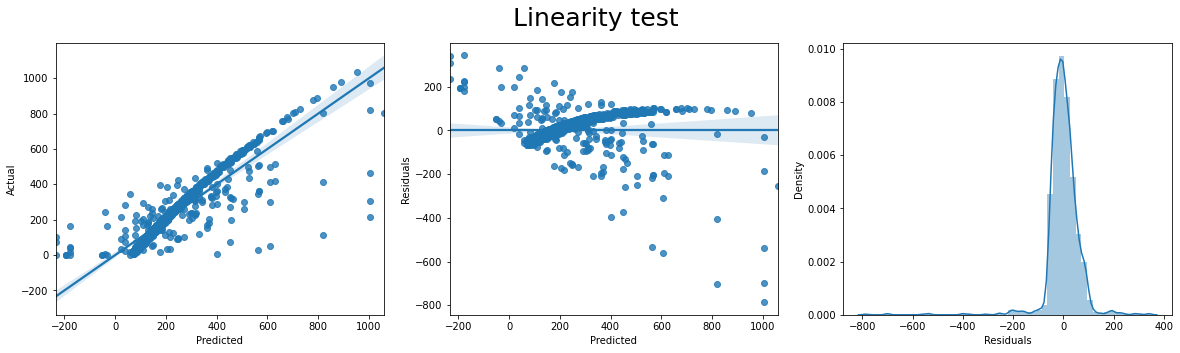

In [283]:
# residual analysis to determine whether assumption of linearity was correct
residuals3 = regression_model3.resid
predy_train3 = regression_model3.fittedvalues
#y_train3 = y_train3.reshape(y_train3.shape[0], )

linearity_check(x_train3, y_train3, residuals3, predy_train3)

In [268]:
regression_model4, y_train4, x_train4, y_test4, x_test4, predy_test4\
= regression(['flow_log'], ['station_log', 'cycleway_log', 'footway_log', 'pedestrian_log'], ja)

Shape of the training set is (1863, 12) and of the testing set is (466, 12).
1
2
4
5
6
7


In [269]:
print(regression_model4.summary())

                            OLS Regression Results                            
Dep. Variable:               flow_log   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     9.407
Date:                Sun, 08 Nov 2020   Prob (F-statistic):           1.58e-07
Time:                        17:42:16   Log-Likelihood:                -2408.2
No. Observations:                1863   AIC:                             4826.
Df Residuals:                    1858   BIC:                             4854.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.4285      0.155     28.

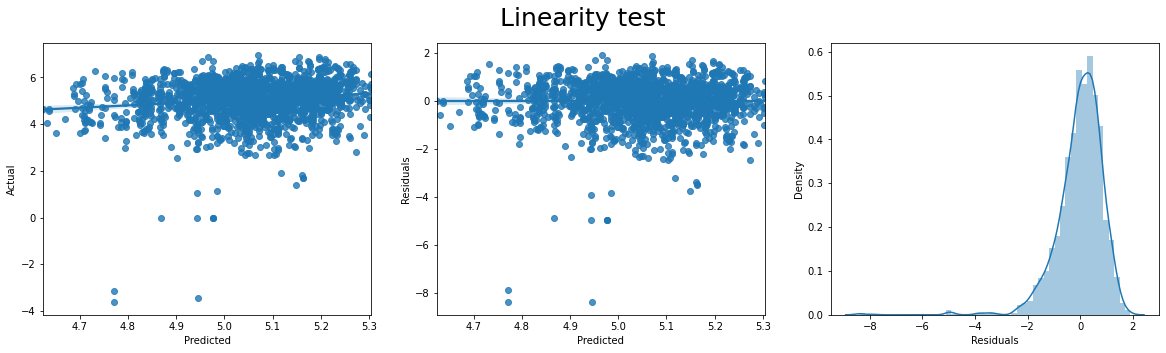

In [270]:
# residual analysis to determine whether assumption of linearity was correct
residuals4 = regression_model4.resid
predy_train4 = regression_model4.fittedvalues
#y_train4 = y_train4.reshape(y_train4.shape[0], )

linearity_check(x_train4, y_train4, residuals4, predy_train4)

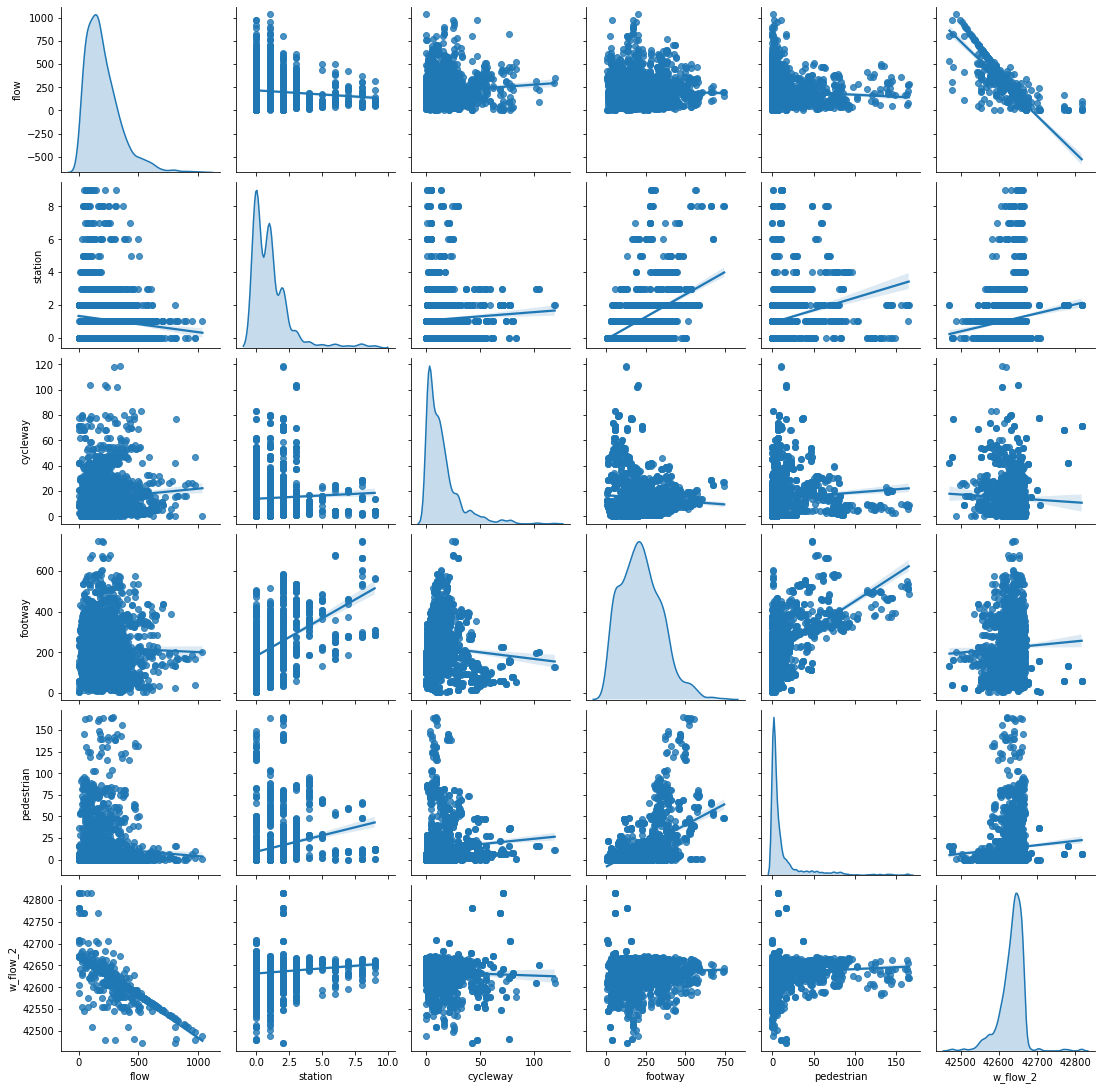

In [274]:
_ = sns.pairplot(ja[['flow', 'station', 'cycleway', 'footway', 'pedestrian', 'w_flow_2']], kind='reg', diag_kind='kde')